In [49]:
import numpy as np
from scipy.linalg import sqrtm, inv
import matplotlib.pyplot as plt
from scipy.linalg import eig
from scipy.linalg import svd
from cycler import cycler
import pandas as pd
from scipy.optimize import curve_fit
import math
import seaborn as sns

plt.rcParams['axes.prop_cycle'] = cycler(color=plt.cm.tab20.colors)

level = [1,2,3,5,7,10,20,30,50,70,100,125,150, 175, 200, 225, 250, 300, 350, 400, 450,  500, 550,600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
def dgbd_model(r, A, a, b, P):
    return np.log(A) + b*np.log(P+1-r) - a*np.log(r)#A * (P + 1 - r) ** b / r ** a 

# 拟合，不包括P参数，P为常数
def dgbd_model_noP(r, A, a, b):
    P = r.max()
    return dgbd_model(r, A, a, b, P)

def dgbd_fit(x, y, p0=[1, 1, 1], title='dgbd'):
    popt, pcov = curve_fit(dgbd_model_noP, x, y, p0=p0, maxfev=5000)

    print("拟合参数A, a, b:", popt)

    # 拟合曲线
    t_fit = dgbd_model_noP(x, *popt)

    plt.scatter(x, y, label='Data')
    plt.plot(x, t_fit, color='red', label='DGBD Fit')
    plt.xlabel('index')
    plt.ylabel('value')
    plt.title(title)
    plt.legend()
    plt.show()
    
    return popt

def get_positive_contributions(jac_arr):    
    ave_sig = []
#     print(jac_arr.shape)
    for i in range(1, jac_arr.shape[0]+1)[::-1]:
        ave_sig.append(np.mean(jac_arr[0:i]))

    output = []
    for id in range(len(ave_sig)-1):
        diff = ave_sig[id+1] - ave_sig[id]
        output.append(diff)
    return output

def compute_entropy(jac_arr):
    increments = get_positive_contributions(jac_arr)
    if not increments:
        return 0.0
    
    total = sum(increments)
    # If total is 0, there's no variation => 0.0 entropy
    if total == 0:
        return 0.0
    
    # Normalize to probabilities
    probabilities = [x / total for x in increments]

    # Compute Shannon entropy (base 2)
    entropy = 0.0
    for p in probabilities:
        # Only compute for p > 0 to avoid math domain errors
        if p > 0:
            entropy -= p * math.log2(p)

    return entropy

def gini(jac_mean):
    return np.cumsum(jac_mean)[-1] / len(jac_mean) - 0.5

def svd_jacs(test_id_first, start, end, interval, seed, eps):
    jacs = {i:[] for i in range(start, end, interval)}
    us = {i:[] for i in range(start, end, interval)}
    vts = {i:[] for i in range(start, end, interval)}
    mats = {i:[] for i in range(start, end, interval)}
    Sigs = {i:[] for i in range(start, end, interval)}
    for k in range(seed):
        test_id = test_id_first + str(k)
        for i in range(start, end, interval):
            str_i = f'{i:04d}'
            mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy')
            L = np.load(f'../results/cov_L/{test_id}/L_{str_i}.npy')
                
            u, s, vt = cal_W(mat, L, eps)
            jacs[i].append(s)
            us[i].append(u)
            vts[i].append(vt)
            mats[i].append(mat)
            Sigs[i].append(L)

    return jacs, us, vts, mats, Sigs

def plot_singular_cum(test_id_first, eps = 'all', seed = 0, window=5, window2='all', start=1, end=16435, interval=108, seq_len=30, log_bool=False):
    start_date = pd.to_datetime("1979/01/01", format="%Y/%m/%d")
    singular, us, vts, mats, Sigs = svd_jacs(test_id_first, start, end, interval, seed, eps)
    gn_dic = {}
    gn_dic_std = {}
    entropy_dic = {}

    for i in range(start, end, interval):
        gn_ls = []
        for k in range(seed):
            jac_arr = np.array(singular[i][k])
            entropy = compute_entropy(jac_arr)
            if log_bool:
                jac_arr = np.log(jac_arr)
            jac_mean = jac_arr #np.mean(jac_arr, axis=0)
            jac_mean_cum = np.cumsum(jac_mean)
            jac_mean_cum /= jac_mean_cum[-1]
            gn = gini(jac_mean_cum)
            gn_ls.append(gn)
        
        gn_dic[i] = np.mean(gn_ls)
        gn_dic_std[i] = np.std(gn_ls)
        entropy_dic[i] = entropy
 
    return gn_dic, entropy_dic, gn_dic_std, singular, us, vts, mats, Sigs

def analysis_u(us, seq_len, dims, start, end, interval, target):
    start_date = pd.to_datetime("1979/01/01", format="%Y/%m/%d")
    for j in target:
        for i in range(start, end, interval):
            time_start = start_date + pd.Timedelta(days=i+seq_len)
            time_end = time_start + pd.Timedelta(days=interval)
            time_str = time_start.strftime("%Y-%m-%d") + '--' + time_end.strftime("%Y-%m-%d")
            u = np.array(us[i])
            u_col1 = u[0, :, j]
            u_col1 = u_col1.reshape(seq_len,dims)
            u_col1 = np.abs(u_col1)
            n_ticks = u_col1.shape[1]
            x_ticks = u_col1.shape[0]
            plt.figure(dpi=150)
            sns.heatmap(u_col1.T)
            plt.ylabel('level(hpa)')
            plt.xlabel('time(day)')
            plt.xticks(ticks=np.arange(x_ticks) + 0.5)
            plt.yticks(ticks=np.arange(n_ticks) + 0.5, labels=level[:n_ticks],rotation=0,fontsize=6)
            plt.title(time_str+"_index={0}".format(j))
            plt.show()
            plt.close()

def analysis_u_mean(us, seq_len, dims, start, end, interval, targets):
    start_date = pd.to_datetime("1979/01/01", format="%Y/%m/%d")
    cof_ls = []
    for i in range(start, end, interval):
        time_start = start_date + pd.Timedelta(days=i+seq_len)
        time_end = time_start + pd.Timedelta(days=interval)
        time_str = time_start.strftime("%Y-%m-%d") + '--' + time_end.strftime("%Y-%m-%d")
        u = np.array(us[i])
        u_col1 = u[0, :, :targets]
        u_col1 = np.mean(u_col1, axis=-1)
        u_col1 = u_col1.reshape(seq_len,dims)
        u_col1 = np.abs(u_col1)
        n_ticks = u_col1.shape[1]
        x_ticks = u_col1.shape[0]
        coarse_cof = np.sum(u_col1[:,5:10])
        coarse_cof_all = np.sum(u_col1)
        print('qbo_cof: '+str(coarse_cof/coarse_cof_all))
        cof_ls.append(coarse_cof/coarse_cof_all)
        plt.figure(dpi=100)
        sns.heatmap(u_col1.T)
        plt.ylabel('level(hpa)')
        plt.xlabel('time')
        plt.xticks(ticks=np.arange(x_ticks) + 0.5)
        plt.yticks(ticks=np.arange(n_ticks) + 0.5, labels=level[:n_ticks],rotation=0,fontsize=6)
        plt.title(time_str+"_n={0}".format(targets))
        plt.show()
    plt.figure()
    plt.plot(cof_ls, marker='o', linestyle='-')
    plt.show()
    
def create_block_diagonal_matrix(matrix1, matrix2):
    if matrix1.ndim != 2 or matrix2.ndim != 2:
        raise ValueError("The input matrix must be two-dimensional.")
    if matrix1.shape[0] != matrix1.shape[1] or matrix2.shape[0] != matrix2.shape[1]:
        raise ValueError("The input matrix must be a square matrix.")
    n1 = matrix1.shape[0]
    n2 = matrix2.shape[0]
    result_dim = n1 + n2
    result = np.zeros((result_dim, result_dim), dtype=matrix1.dtype)
    result[:n1, :n1] = matrix1
    result[n1:, n1:] = matrix2
    return result

def cal_W(A, Sigma, eps='all'):
    n = A.shape[0]
    matrix_a = np.conj(A).T @ np.linalg.inv(Sigma) @ A
    matrix_b = np.linalg.inv(Sigma)
    block_matrix = create_block_diagonal_matrix(matrix_a, matrix_b)
    U, S, VT = svd(block_matrix, full_matrices=False)
    #U = np.abs(U)
    if eps == "auto":
        diff = np.diff(S) 
        max_diff_index = np.argmax(np.abs(diff))   
        eps = S[max_diff_index] - 0.1
    
    if not isinstance(eps, str):
        m = np.sum(S >= float(eps)) 
        if m==0:
            m=1
        U = U[:, :m]
        S = S[:m]
    U2 = U[:n,:] + U[n:,:]
    U2 = U2 @ np.diag(S)
    U2U, S2, V2T = svd(U2, full_matrices=False)

    return np.abs(U2U), S2, V2T

def cal_W2(A, Sigma, eps='all'):
    n = A.shape[0]
    matrix_a = np.conj(A).T @ np.linalg.inv(Sigma) @ A
    U, S, VT = svd(matrix_a, full_matrices=False)
    U = np.abs(U)
    
    if not isinstance(eps, str):
        m = np.sum(S >= float(eps)) 
        if m==0:
            m=1
        U = U[:, :m]
        S = S[:m]

    return U, S, VT

def extract_rows_with_interval(matrix, start_row_index, interval=37):
    if not isinstance(matrix, np.ndarray):
        try:
            matrix = np.array(matrix)
        except Exception as e:
            print(f"错误：无法将输入转换为NumPy数组: {e}")
            return np.array([]) # 返回一个空数组

    # 检查矩阵是否至少是二维的
    if matrix.ndim < 2:
        print("错误：输入矩阵的维度必须至少为2。")
        return np.array([])

    num_rows = matrix.shape[0]

    # 检查起始行索引是否有效
    if start_row_index < 0 or start_row_index >= num_rows:
        print(f"错误：起始行索引 {start_row_index} 超出了矩阵的有效行范围 [0, {num_rows - 1}]。")
        return np.array([]) # 返回一个空数组

    # 生成要提取的行的索引列表
    # range(start, stop, step)
    row_indices_to_extract = list(range(start_row_index, num_rows, interval))
    print(row_indices_to_extract)

    if not row_indices_to_extract:
        print("根据给定的起始行和间隔，没有行可以被提取。")
        return np.array([])

    # 使用高级索引直接从原矩阵中提取这些行
    extracted_matrix = matrix[row_indices_to_extract, :] # ':' 表示提取所有列

    return extracted_matrix

def extract_cols_with_interval(matrix, start_col_index, interval=37):
    if not isinstance(matrix, np.ndarray):
        try:
            matrix = np.array(matrix)
        except Exception as e:
            print(f"错误：无法将输入转换为NumPy数组: {e}")
            return np.array([]) # 返回一个空数组

    # 检查矩阵是否至少是二维的
    if matrix.ndim < 2:
        print("错误：输入矩阵的维度必须至少为2。")
        return np.array([])

    num_cols = matrix.shape[1] # 获取总列数

    # 检查起始列索引是否有效
    if start_col_index < 0 or start_col_index >= num_cols:
        print(f"错误：起始列索引 {start_col_index} 超出了矩阵的有效列范围 [0, {num_cols - 1}]。")
        return np.array([]) # 返回一个空数组

    # 生成要提取的列的索引列表
    # range(start, stop, step)
    col_indices_to_extract = list(range(start_col_index, num_cols, interval))

    if not col_indices_to_extract:
        print("根据给定的起始列和间隔，没有列可以被提取。")
        return np.array([])

    # 使用高级索引直接从原矩阵中提取这些列
    # ':' 表示提取所有行
    extracted_matrix = matrix[:, col_indices_to_extract]

    return extracted_matrix

def plot_ce_index(val_dic, val_std, y_lab = "gini",start_idx=0, end_idx=1):
    x_labels0 = list(val_dic.keys())
    y_val = np.array(list(val_dic.values()))
    y_val_std = np.array(list(val_std.values()))
    highlight_mask = [(start_idx <= x <= end_idx) for x in x_labels0]
    highlight_x = [x for x, flag in zip(x_labels0, highlight_mask) if flag]
    highlight_y = [v for v, flag in zip(y_val, highlight_mask) if flag]

    plt.figure(figsize=(8, 4))
    plt.plot(x_labels0, y_val, marker='o', linestyle='-')
    plt.plot(highlight_x, highlight_y, color='red', marker='o', linestyle='-')
    plt.ylabel(y_lab)
    plt.tight_layout()
    plt.show()
    
def log_max_abs_eig(matrix_dic):
    """
    Compute the natural log of the absolute largest eigenvalue for each matrix
    
    Returns:
    list: Natural logs of the absolute largest eigenvalues
    """
    results = []
    x_labels = list(matrix_dic.keys())
    matrix_list = list(matrix_dic.values())
    for idx, matrix in enumerate(matrix_list):
        # Verify matrix is square
        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError(f"Matrix at index {idx} is not square")
            
        # Compute eigenvalues
        eigvals = np.linalg.eigvals(matrix)
        
        # Find absolute largest eigenvalue
        abs_eigvals = np.abs(eigvals)
        max_abs_eig = np.max(abs_eigvals)
        
        # Handle edge case where eigenvalue could be zero
        if max_abs_eig == 0:
            # Zero eigenvalues need special handling for log
            results.append(-np.inf)
        else:
            results.append(np.log(max_abs_eig))
    
    return x_labels,results

def plot_eig_results(x_labels,log_values):
    """
    Create a professional line plot of the eigenvalue logs
    
    Args:
    log_values (list): Natural log values from log_max_abs_eig()
    """
    tick_positions = np.arange(len(x_labels))
    marker_x_positions = tick_positions + 0.5
    
    plt.figure(figsize=(10, 6))
    
    # Create plot with custom styling
    plt.plot(marker_x_positions,log_values, 
             marker='o', 
             markersize=8, 
             linewidth=2.5, 
             color='#1f77b4',
             markerfacecolor='white',
             markeredgewidth=2)
    
    # Customize plot aesthetics
    plt.ylabel('ln(|λ|_max)', fontsize=12)
    #plt.grid(True, linestyle='--', alpha=0.7)
    #plt.xticks(ticks=tick_positions, labels=x_labels, rotation=45, ha='right')
    plt.yticks(fontsize=10)
    
    # Annotate values on the plot
    for i, val in enumerate(log_values):
        plt.annotate(f'{val:.2f}', 
                     (i, val), 
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center',
                     fontsize=9)
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

def macro_analysis(us, mats, start, end, interval):
    start_date = pd.to_datetime("1979/01/01", format="%Y/%m/%d")
    A_ma_ls = {}
    for i in range(start, end, interval):
        time_start = start_date + pd.Timedelta(days=i+seq_len)
        time_str = time_start.strftime("%Y-%m-%d") 
        A_macro = us[i][0].T @ mats[i][0] @  us[i][0] 
        A_macro = np.real(A_macro)
        A_ma_ls[time_str] = A_macro

    x_labels,results = log_max_abs_eig(A_ma_ls)
    plot_eig_results(x_labels,results)
    
def plot_singular_dgbd(singular, start, end, interval):
    start_date = pd.to_datetime("1979/01/01", format="%Y/%m/%d")
    A_dic = {}
    A_dic_std={}
    a_dic={}
    b_dic={}
    for i in range(start, end, interval):
        time_start = start_date + pd.Timedelta(days=i)
        time_end = time_start + pd.Timedelta(days=interval)
        time_str = time_start.strftime("%Y-%m-%d") + '--' + time_end.strftime("%Y-%m-%d")
        s = np.array(singular[i][0])
        x = np.arange(1, len(s)+1)  
        s = np.log(s)
    #     plt.scatter(x, s, label='Data')
    #     plt.xlabel('index')
    #     plt.ylabel('value')
    #     plt.title(time_str)
    #     plt.show()

        param = dgbd_fit(x, s, p0=[0.5, 0.5, 0.5], title=time_str)
        A_dic[i] = param[0]
        A_dic_std[i] = 0
        a_dic[i] = param[1]
        b_dic[i] = param[2]
    return A_dic, A_dic_std, a_dic, b_dic

In [9]:
date1 = pd.to_datetime("2015/04/28", format="%Y/%m/%d") - pd.to_datetime("1979/01/01", format="%Y/%m/%d")
date2 = pd.to_datetime("2019/07/12", format="%Y/%m/%d") - pd.to_datetime("1979/01/01", format="%Y/%m/%d")
date3 = pd.to_datetime("2015/11/01", format="%Y/%m/%d") - pd.to_datetime("1979/01/01", format="%Y/%m/%d")
date4 = pd.to_datetime("2016/04/01", format="%Y/%m/%d") - pd.to_datetime("1979/01/01", format="%Y/%m/%d")
date5 = pd.to_datetime("2019/12/01", format="%Y/%m/%d") - pd.to_datetime("1979/01/01", format="%Y/%m/%d")
date6 = pd.to_datetime("2020/06/01", format="%Y/%m/%d") - pd.to_datetime("1979/01/01", format="%Y/%m/%d")
date3.days, date4.days, date5.days, date6.days  

(13453, 13605, 14944, 15127)

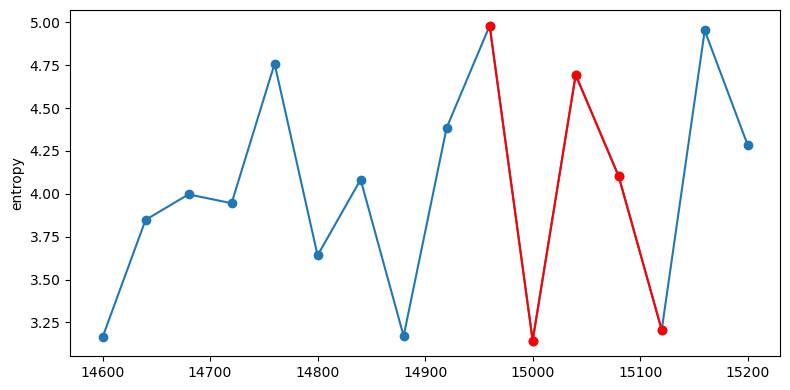

In [54]:
test_id = 'long_term_forecast_test_NN_QBO_ft-1_sl40_pl40_dm1024_nh8_el2_dl1_df2048_fc1_flocvali_first_lam0.0_dtTrue_Exp_'
start = 14600
end = 15201
interval = 40
seq_len = 40

gn_all, entropy_dic, gn_all_std, singular, us, vts, mats, Sigs = plot_singular_cum(test_id, eps='all', seed = 1, start=start, end=end, interval=interval, seq_len=seq_len, log_bool=False)
plot_ce_index(entropy_dic, gn_all_std, y_lab = "entropy", start_idx=14944, end_idx=15127)

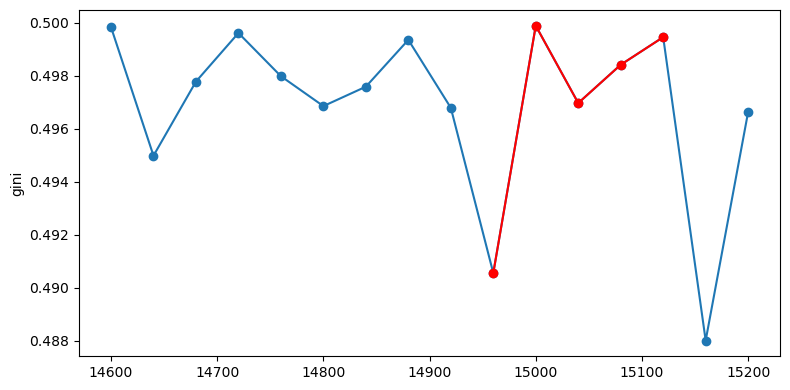

In [55]:
plot_ce_index(gn_all, gn_all_std, start_idx=14944, end_idx=15127)

拟合参数A, a, b: [2.90587685e+05 2.11529749e+00 3.29368870e-01]


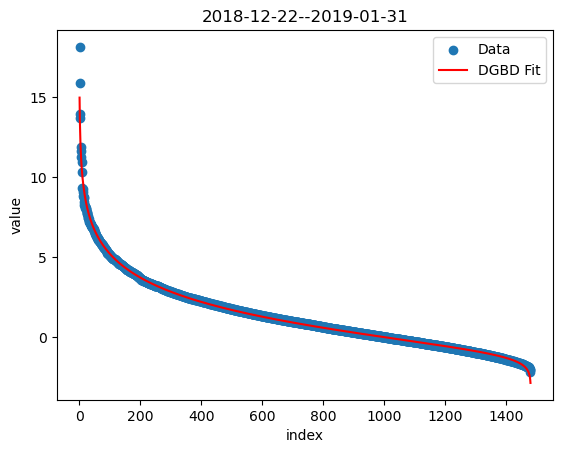

拟合参数A, a, b: [8.68554938e+04 1.99289679e+00 5.16531500e-01]


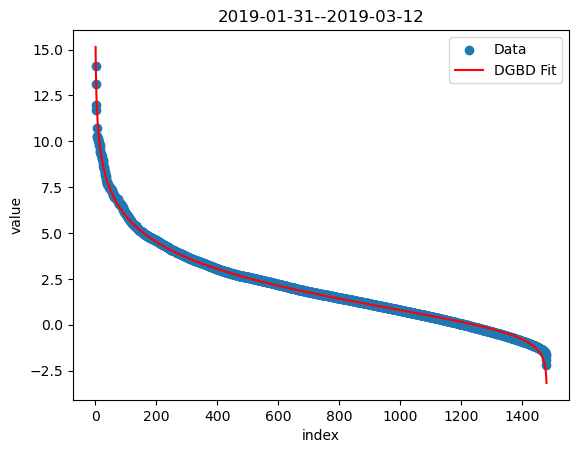

拟合参数A, a, b: [3.24413434e+05 2.05142518e+00 3.33955056e-01]


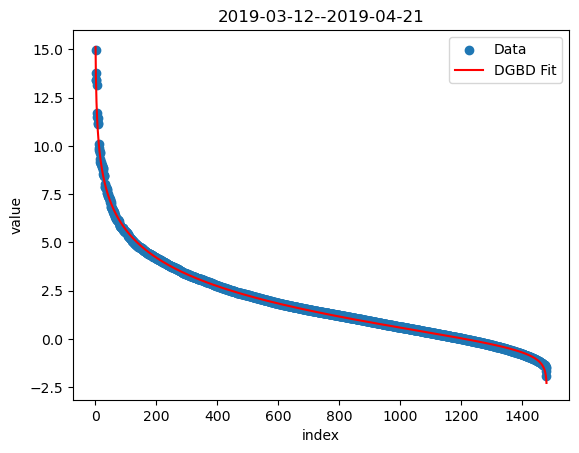

拟合参数A, a, b: [1.32228810e+05 2.08626864e+00 4.71372726e-01]


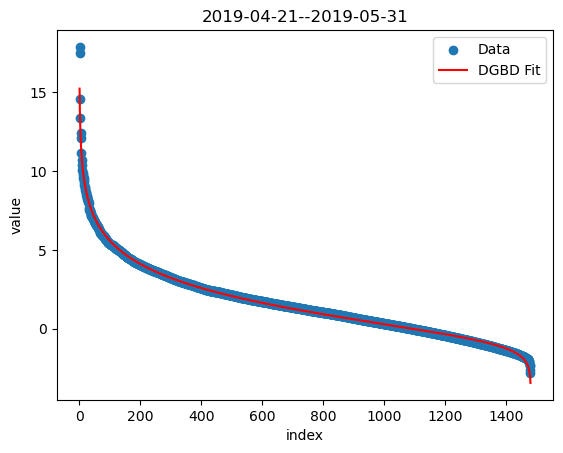

拟合参数A, a, b: [1.61821809e+05 2.10763029e+00 4.50151947e-01]


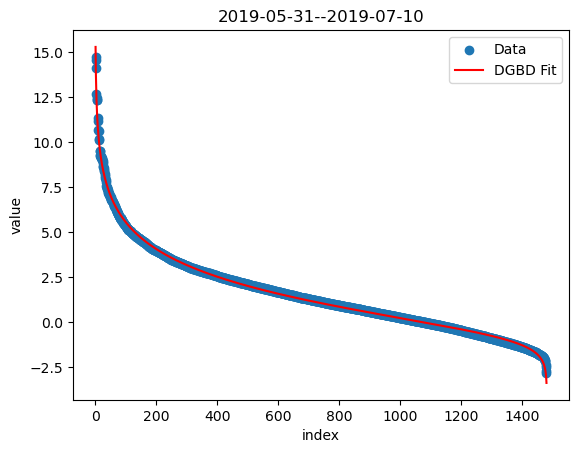

拟合参数A, a, b: [4.88601164e+04 2.04274222e+00 4.43509462e-01]


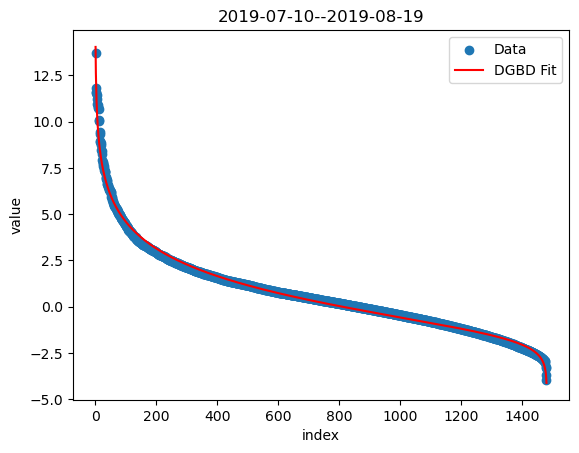

拟合参数A, a, b: [9.85698128e+04 2.09797829e+00 5.27514407e-01]


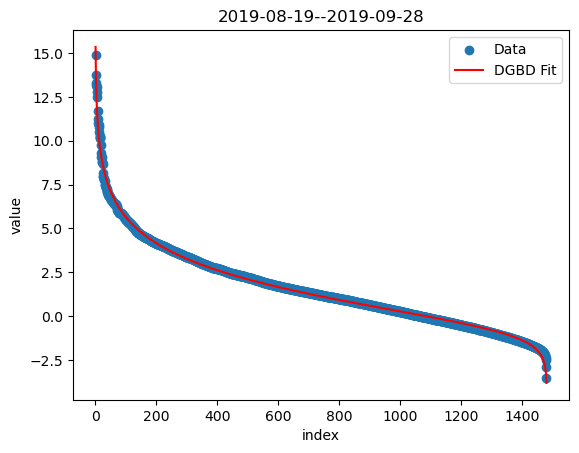

拟合参数A, a, b: [1.84374958e+04 2.04127073e+00 6.56219507e-01]


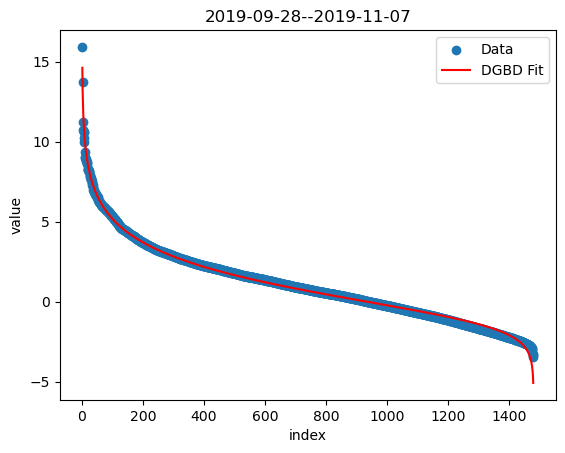

拟合参数A, a, b: [9.76723446e+04 2.24304307e+00 4.99038432e-01]


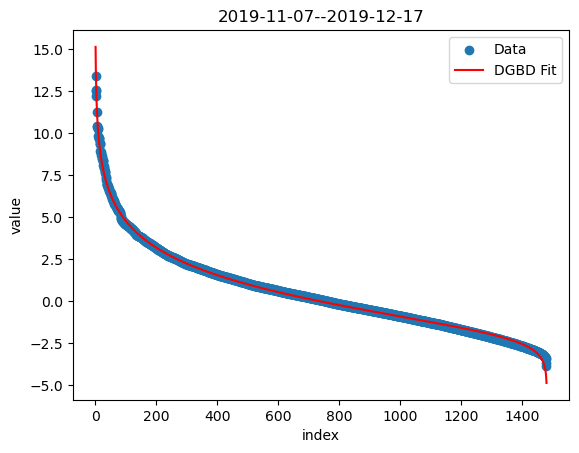

拟合参数A, a, b: [3.87912339e+04 2.12895070e+00 5.92060358e-01]


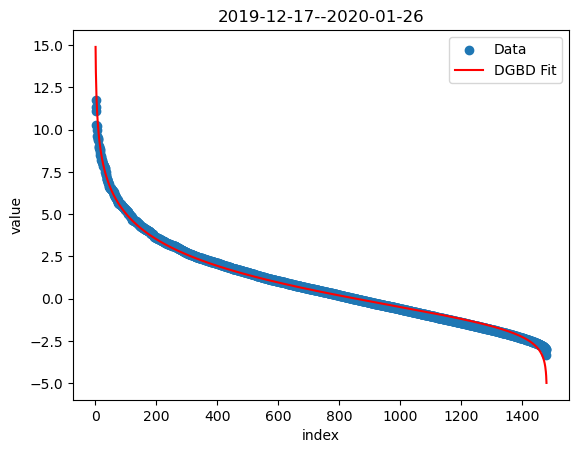

拟合参数A, a, b: [7.92870824e+04 2.12898740e+00 5.23943125e-01]


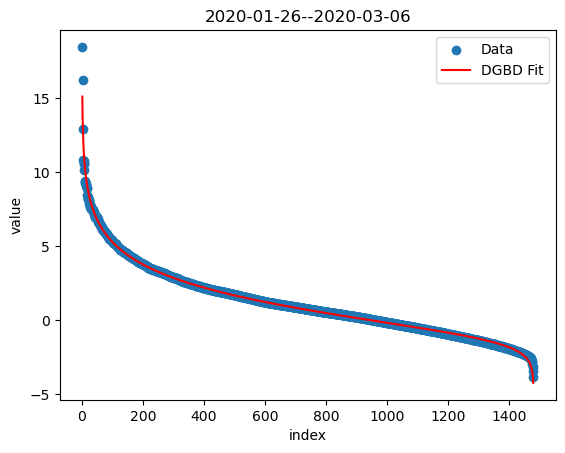

拟合参数A, a, b: [5.58405293e+04 2.10069045e+00 6.07994304e-01]


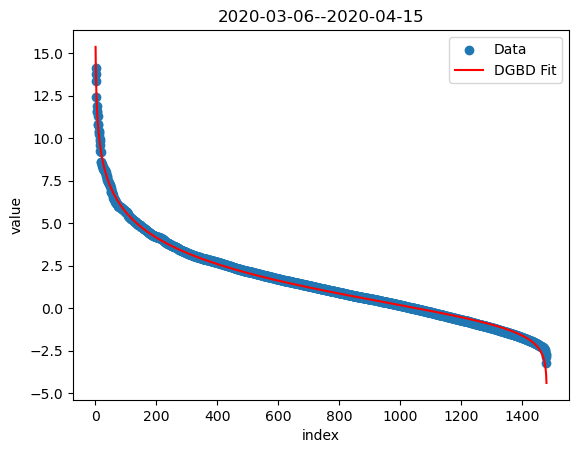

拟合参数A, a, b: [9.67733153e+04 1.99529223e+00 3.69887805e-01]


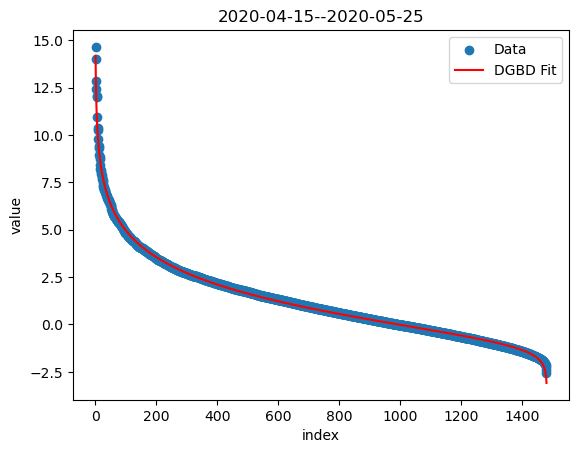

拟合参数A, a, b: [1.03897936e+05 2.03569132e+00 4.83978098e-01]


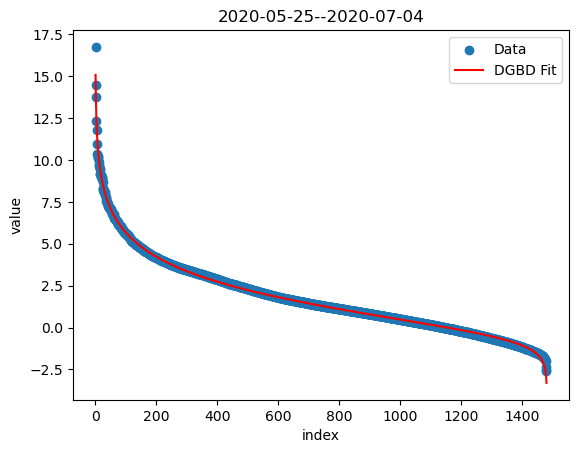

拟合参数A, a, b: [2.14662926e+04 1.89984021e+00 4.98304654e-01]


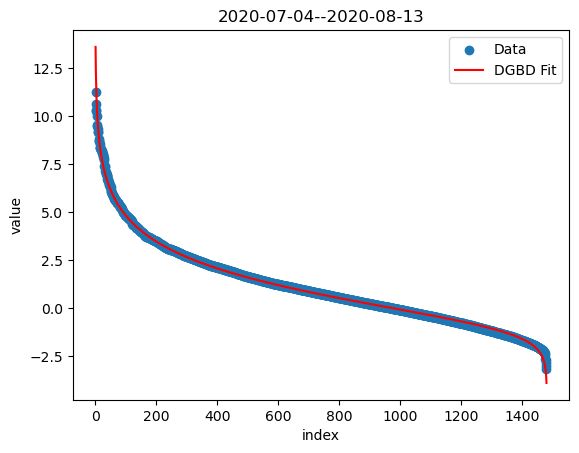

拟合参数A, a, b: [6.68338197e+04 2.03587641e+00 5.38920755e-01]


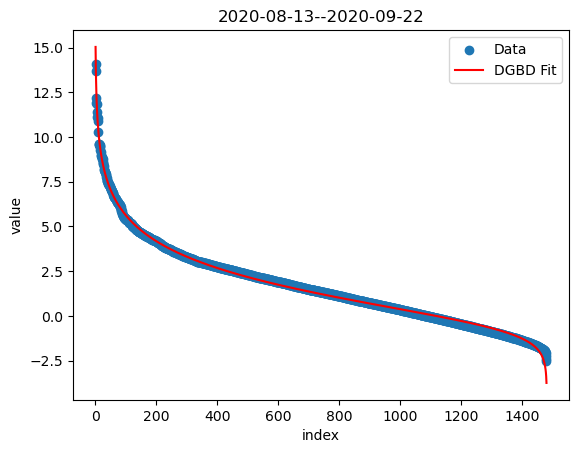

In [56]:
A_dic, A_dic_std, a_dic, b_dic = plot_singular_dgbd(singular, start, end, interval)

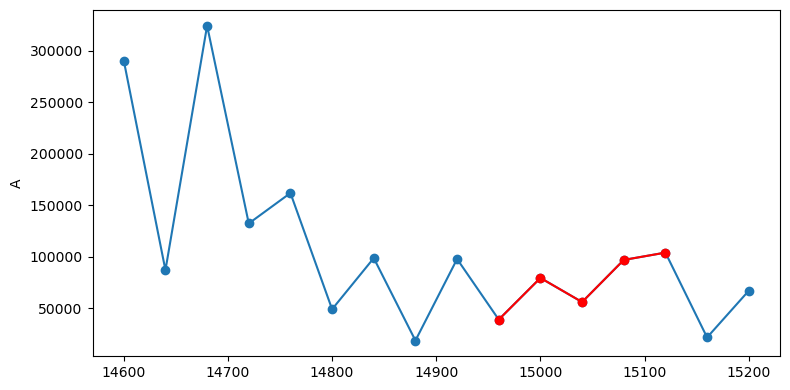

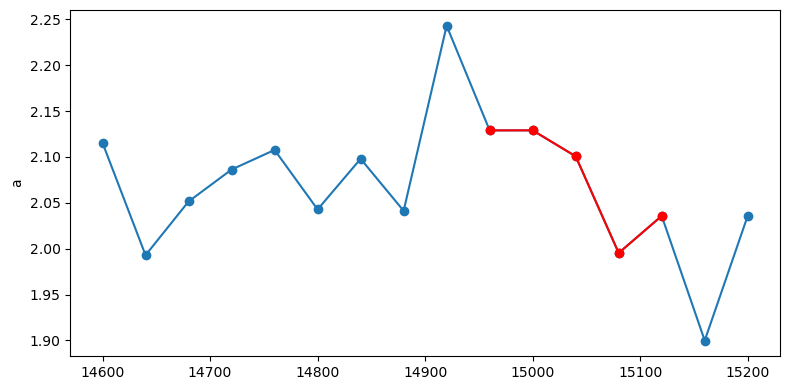

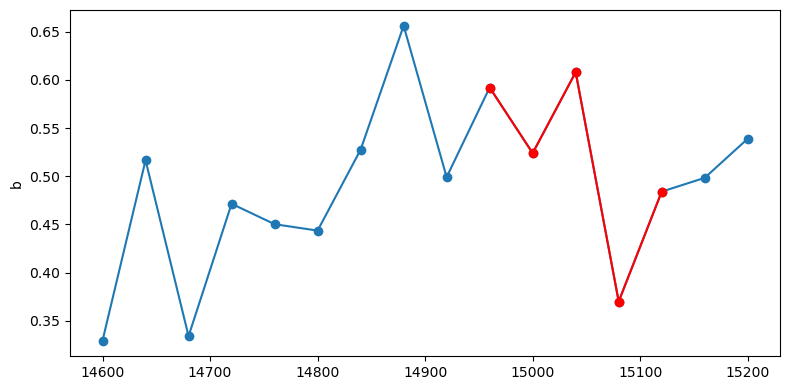

In [57]:
plot_ce_index(A_dic, A_dic_std, y_lab = "A", start_idx=14944, end_idx=15127)
plot_ce_index(a_dic, A_dic_std, y_lab = "a", start_idx=14944, end_idx=15127)
plot_ce_index(b_dic, A_dic_std, y_lab = "b", start_idx=14944, end_idx=15127)

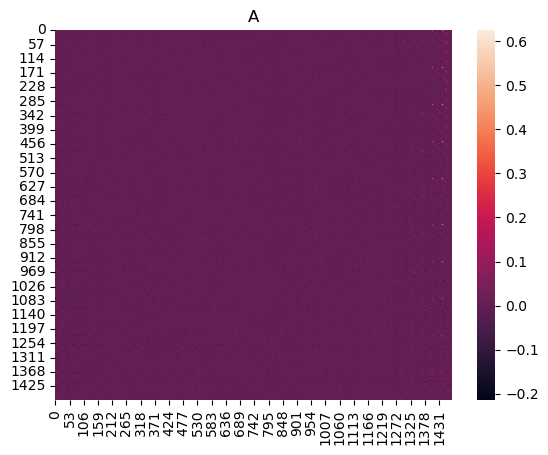

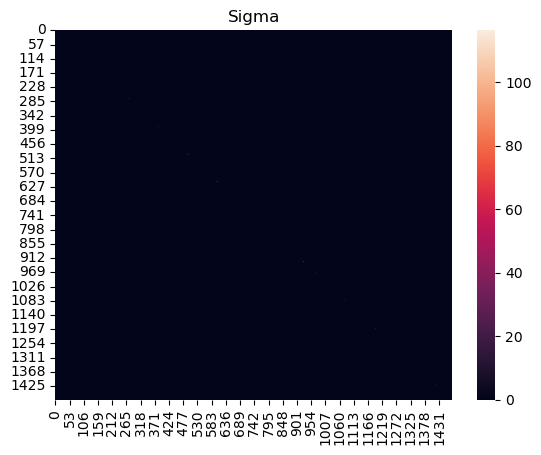

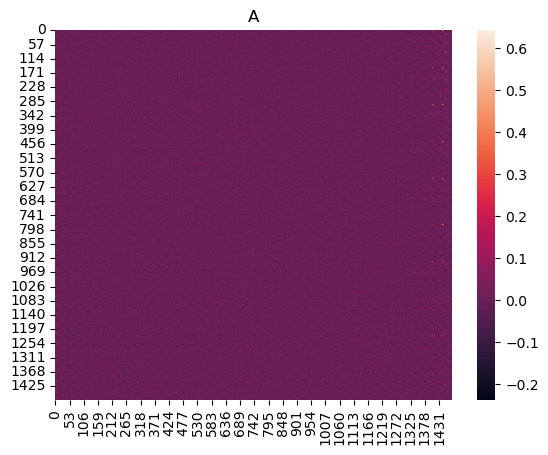

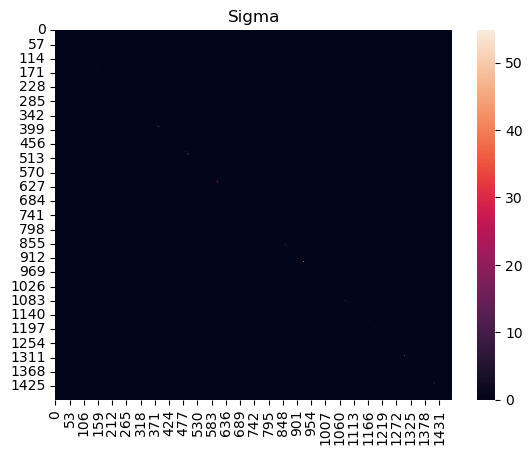

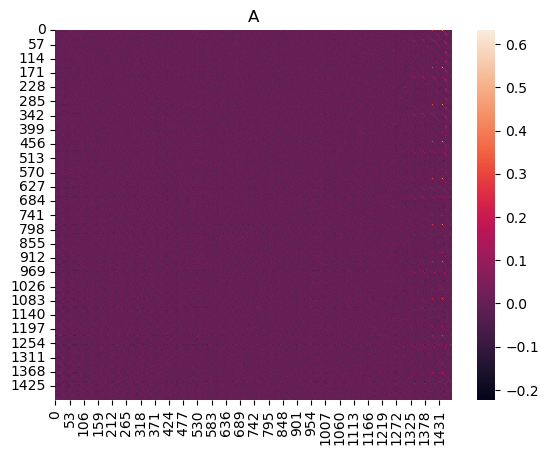

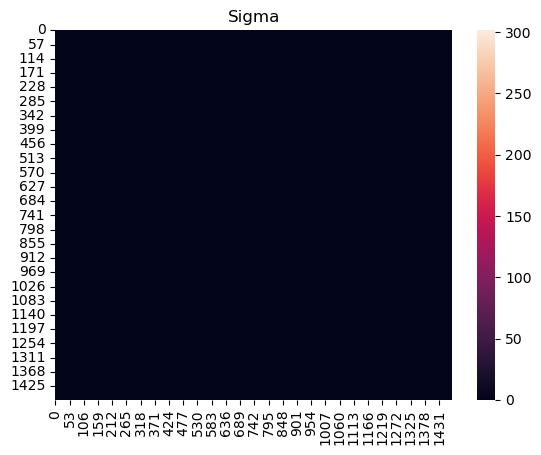

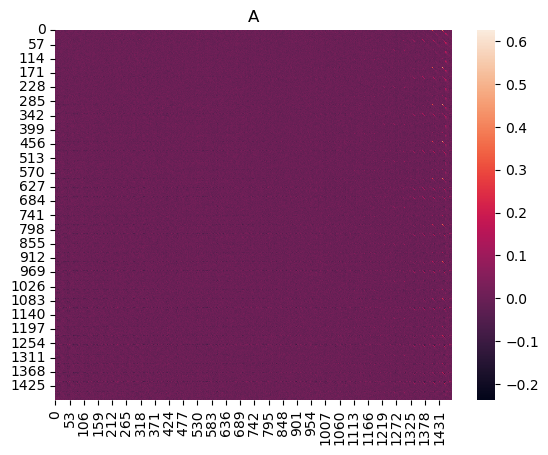

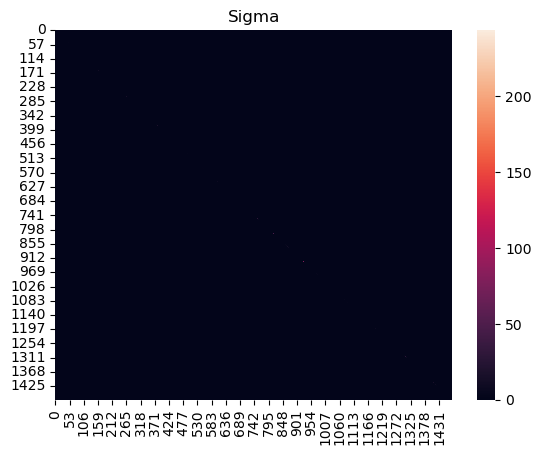

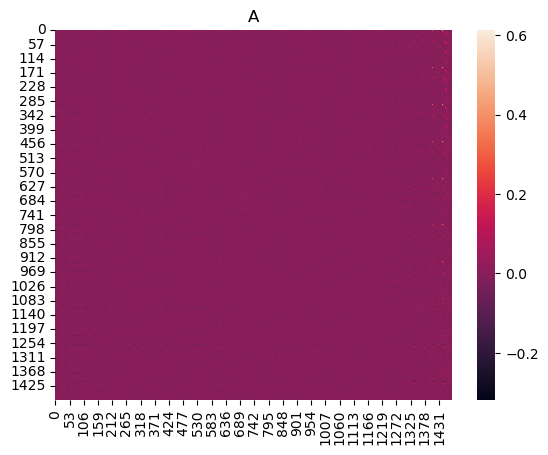

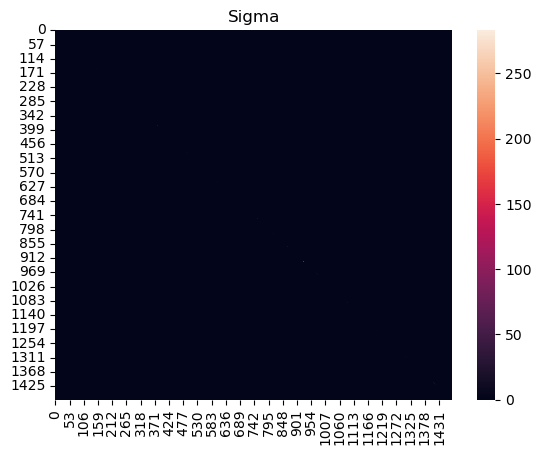

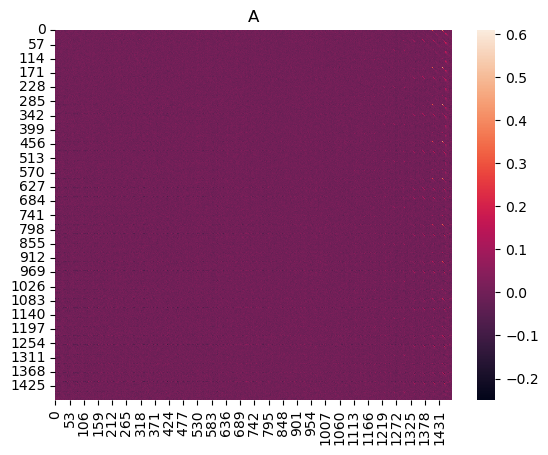

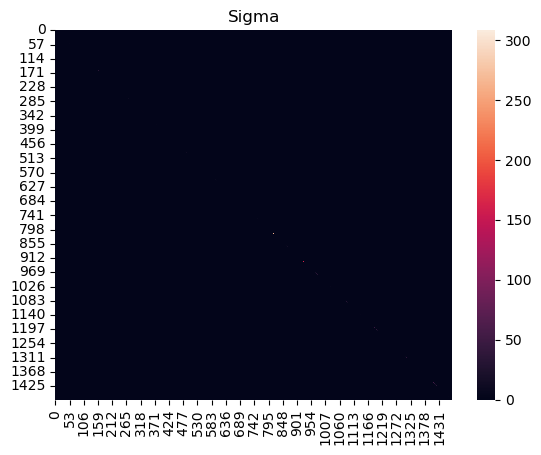

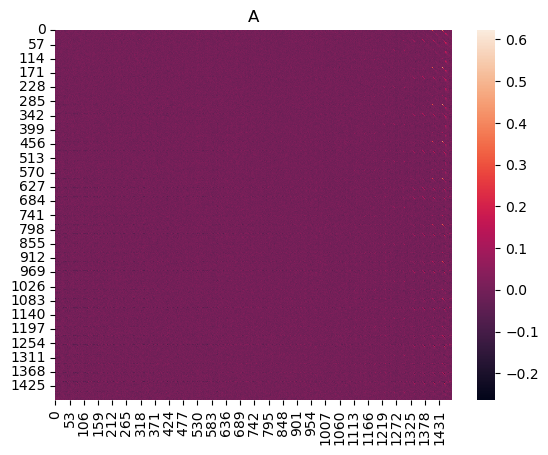

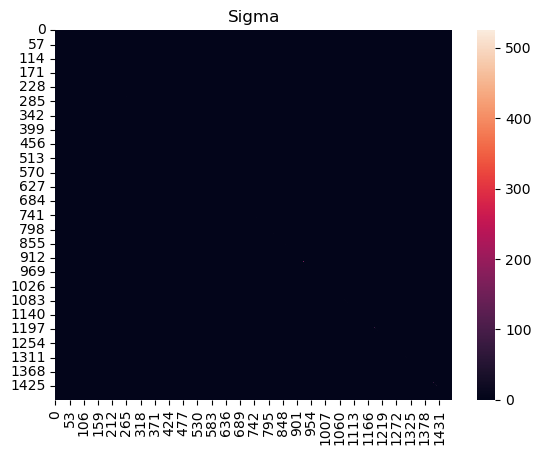

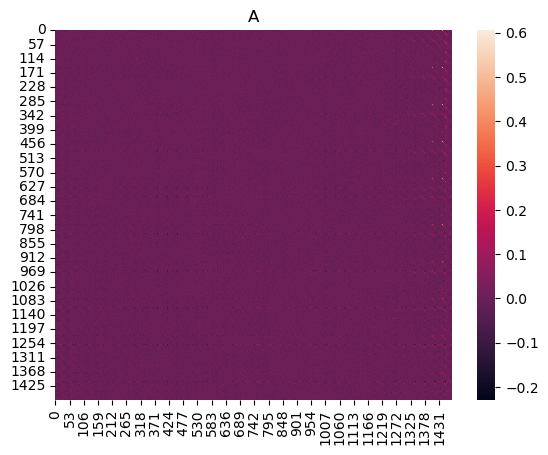

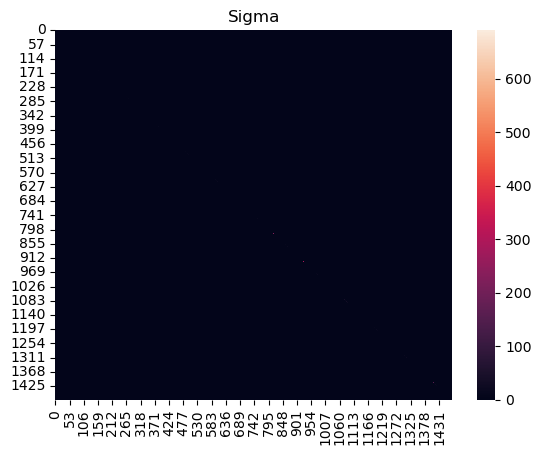

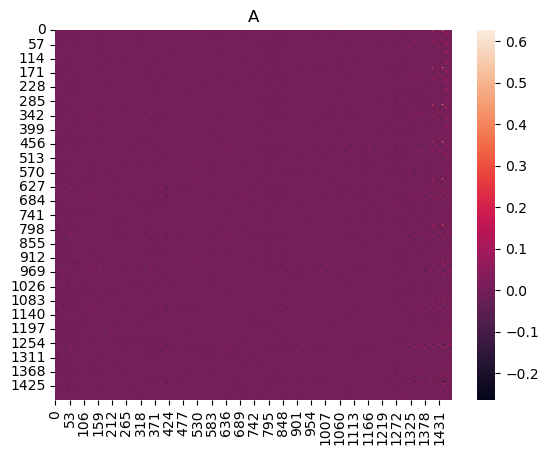

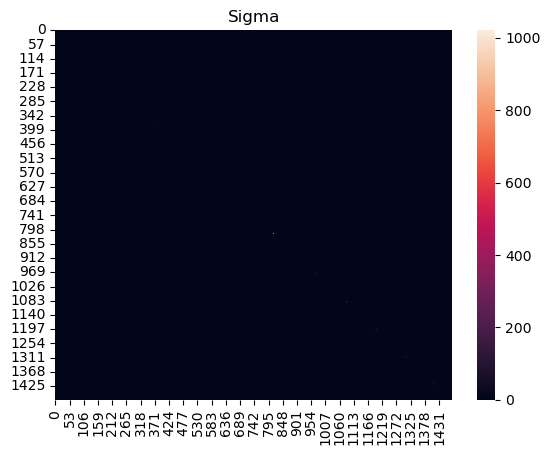

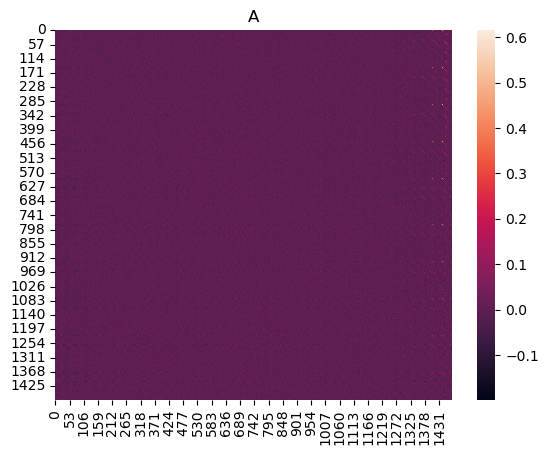

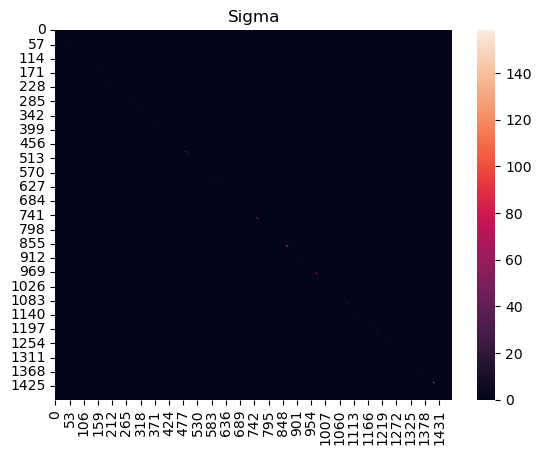

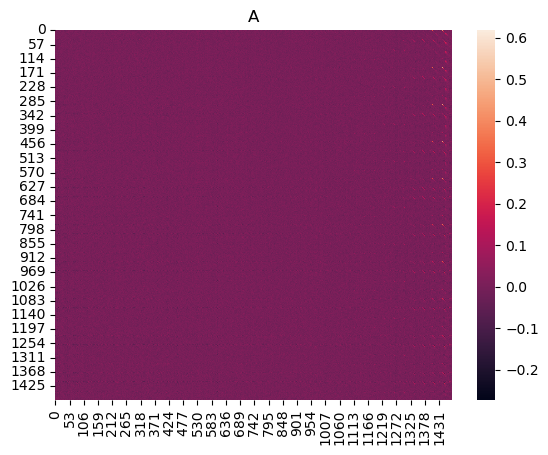

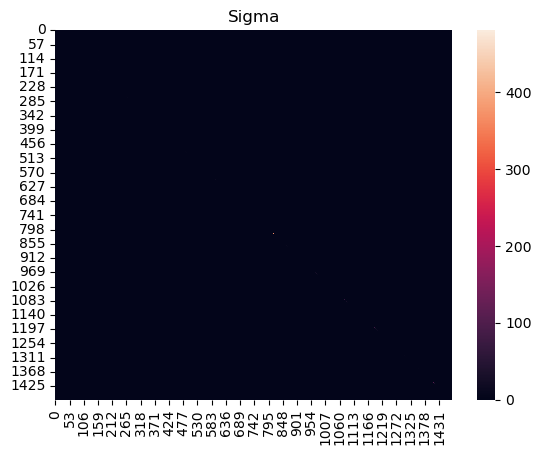

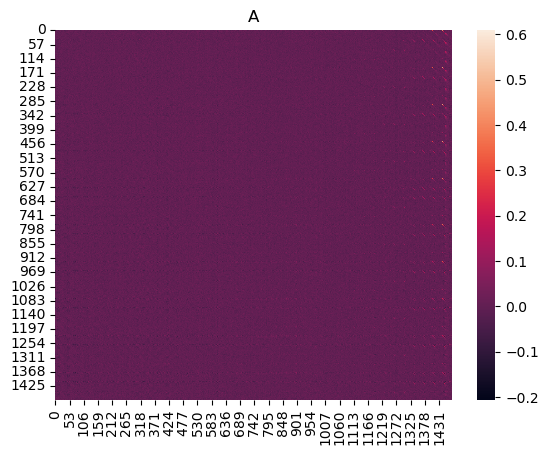

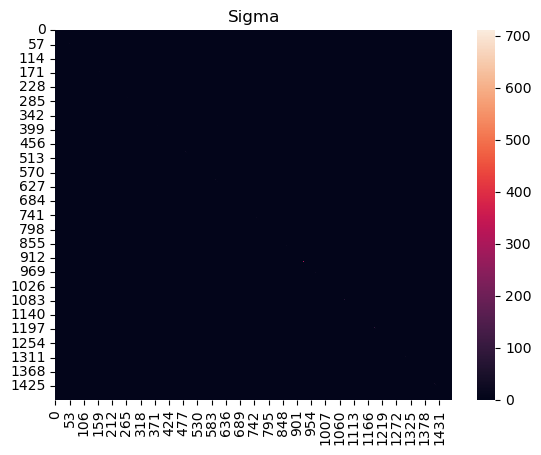

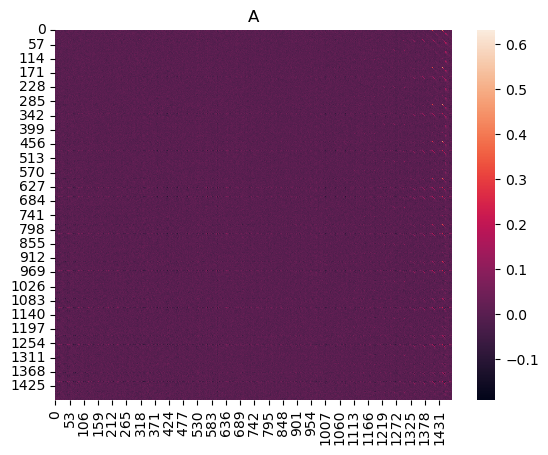

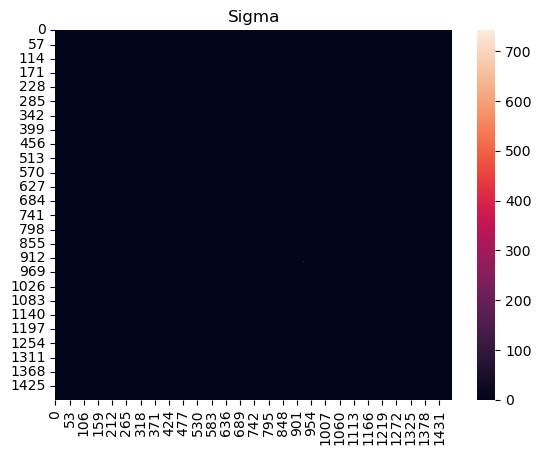

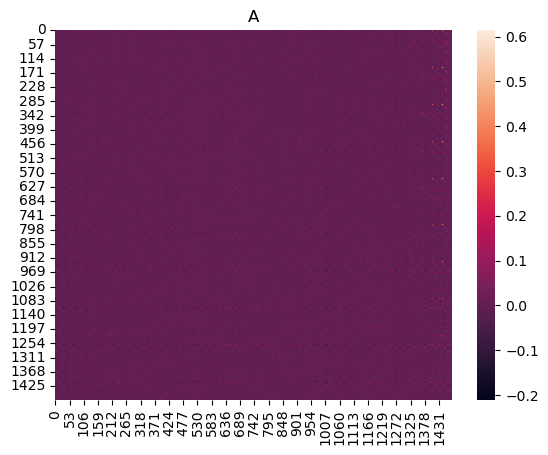

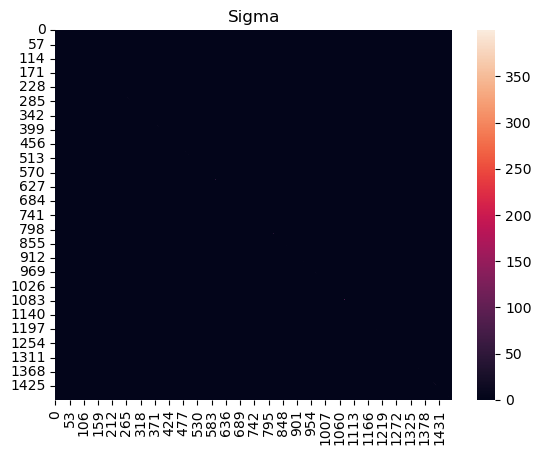

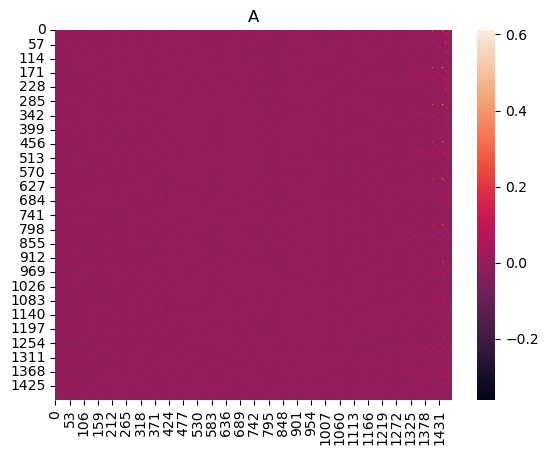

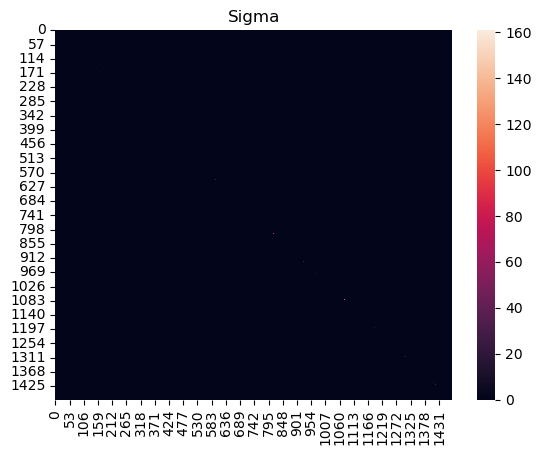

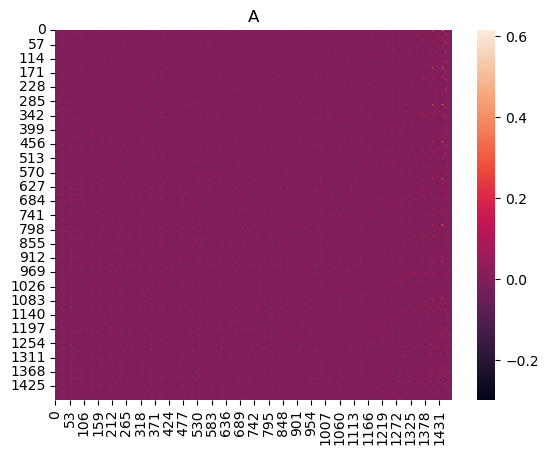

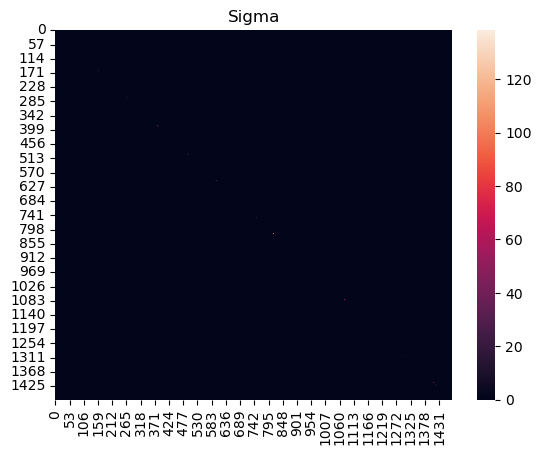

In [58]:
for i in range(start, end, interval):
    sns.heatmap(mats[i][0]) 
    plt.title('A')
    plt.show()
    sns.heatmap(Sigs[i][0])
    plt.title('Sigma')
    plt.show()

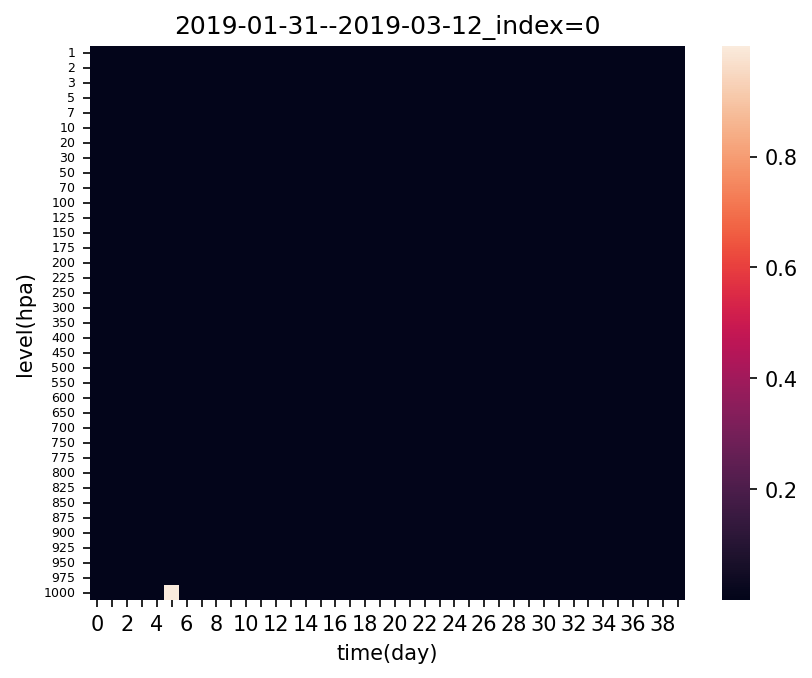

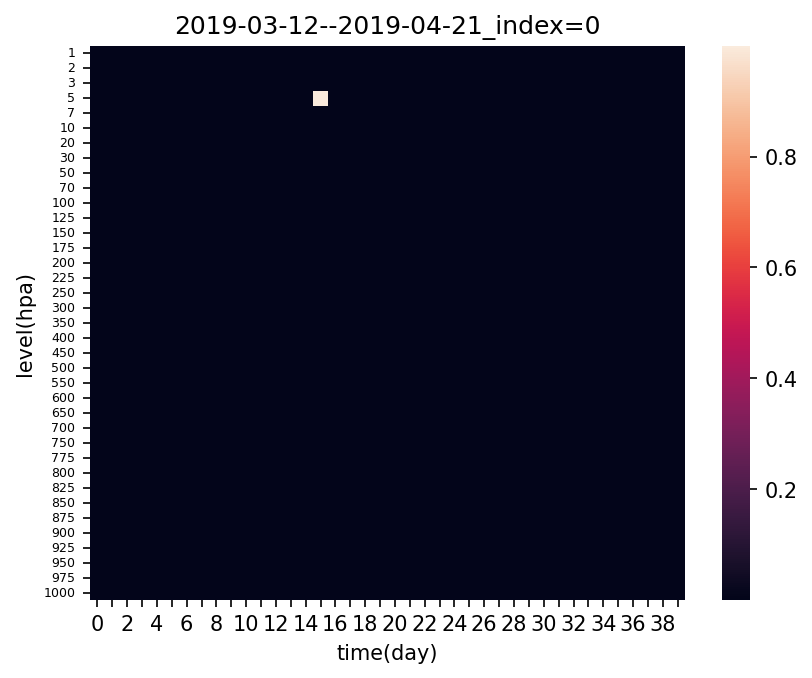

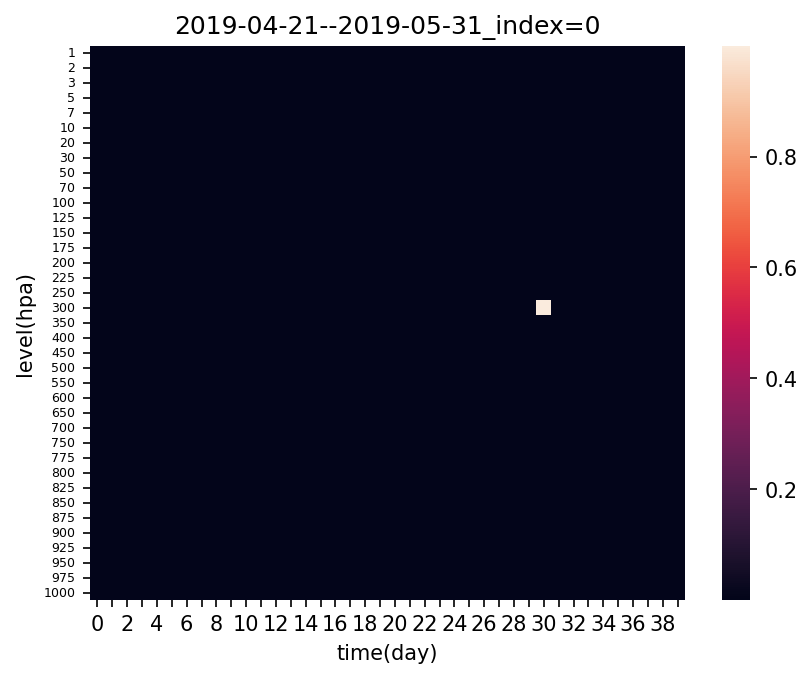

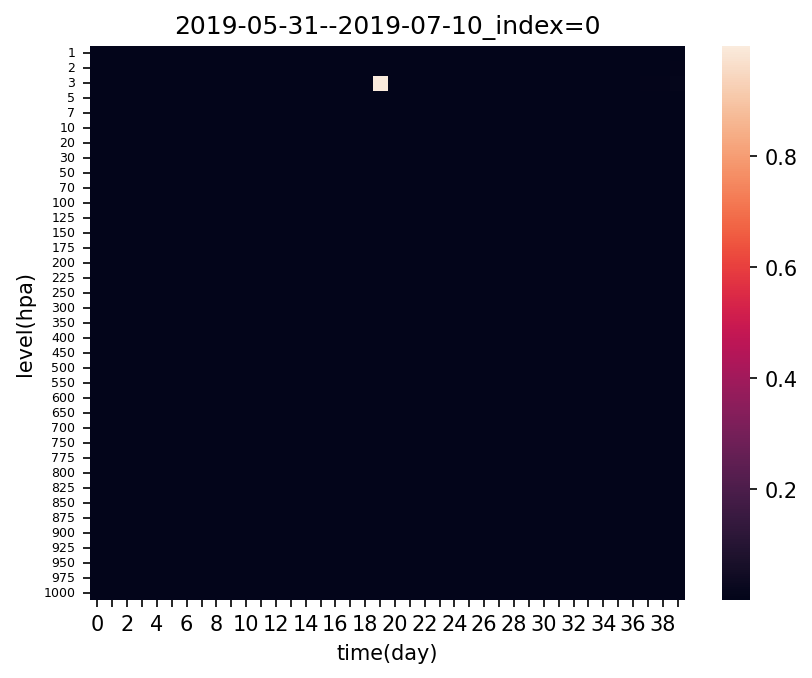

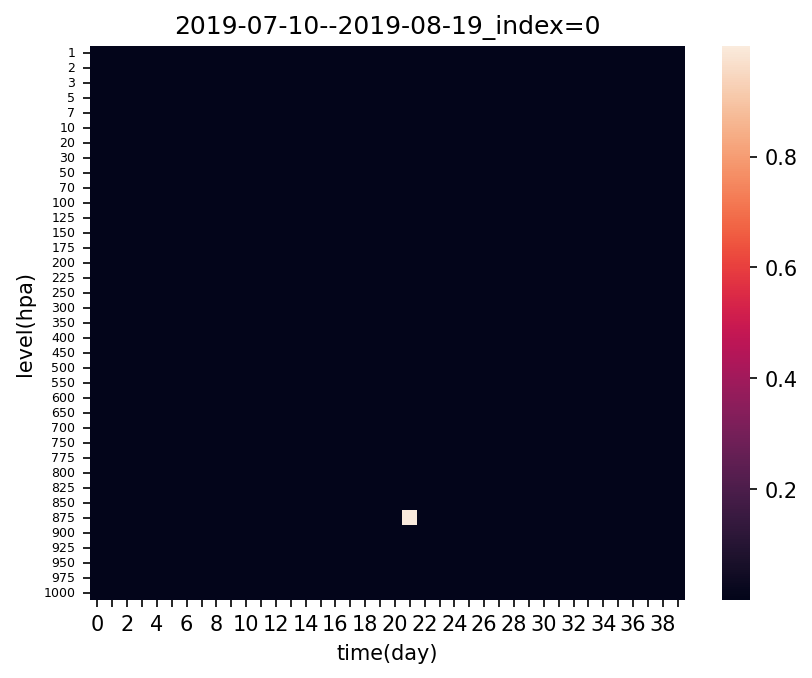

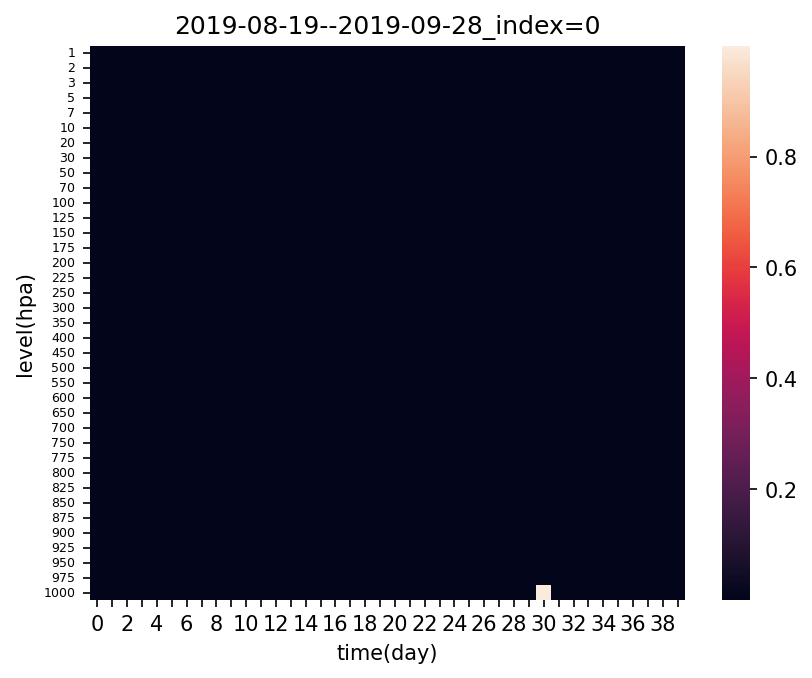

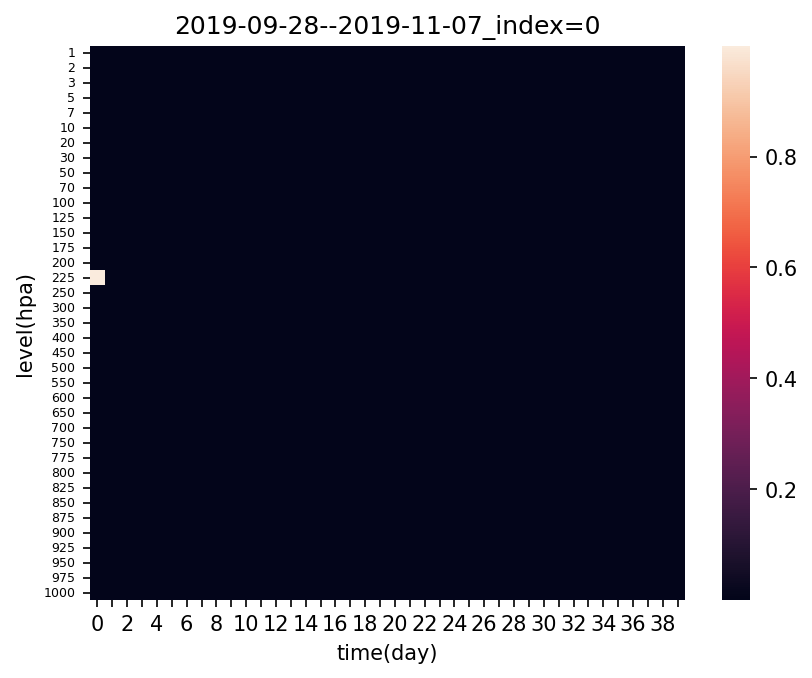

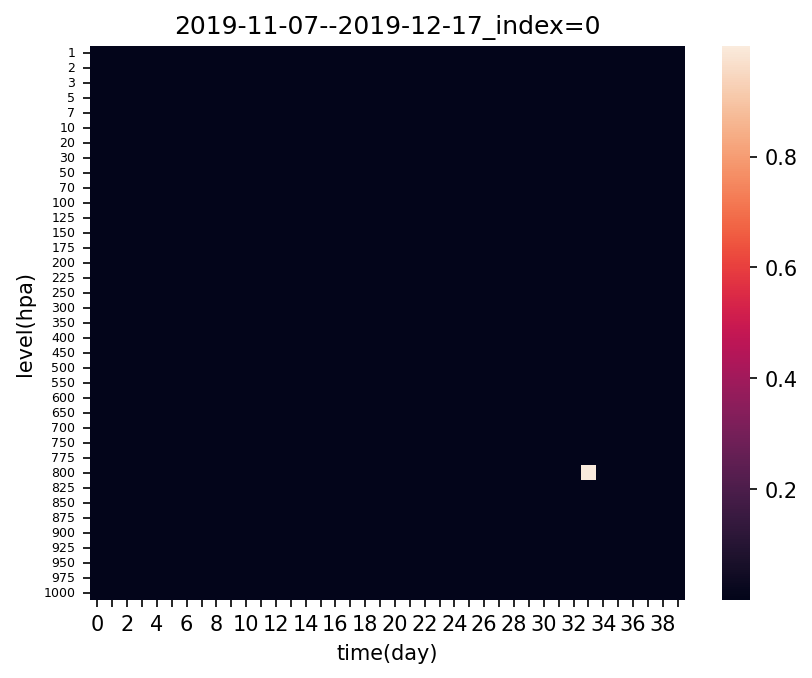

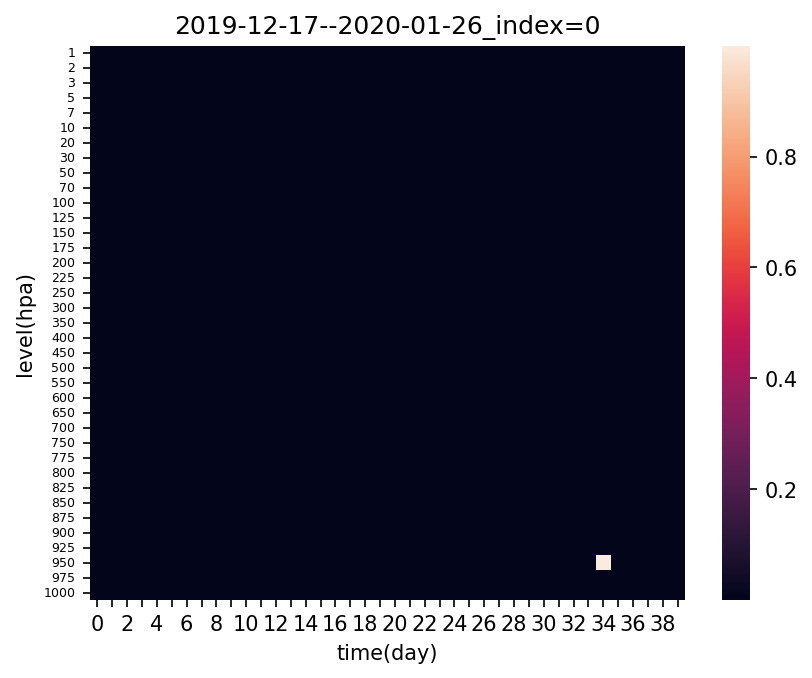

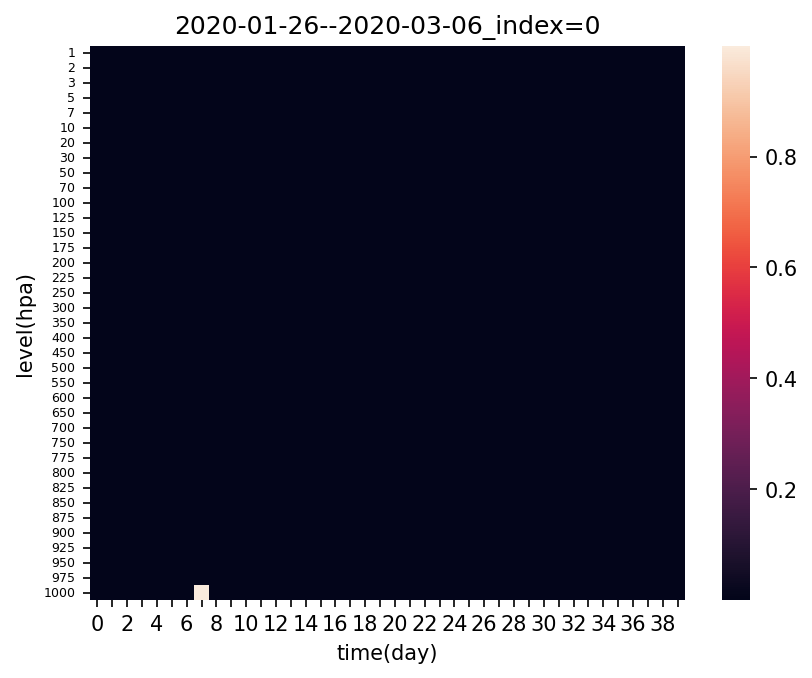

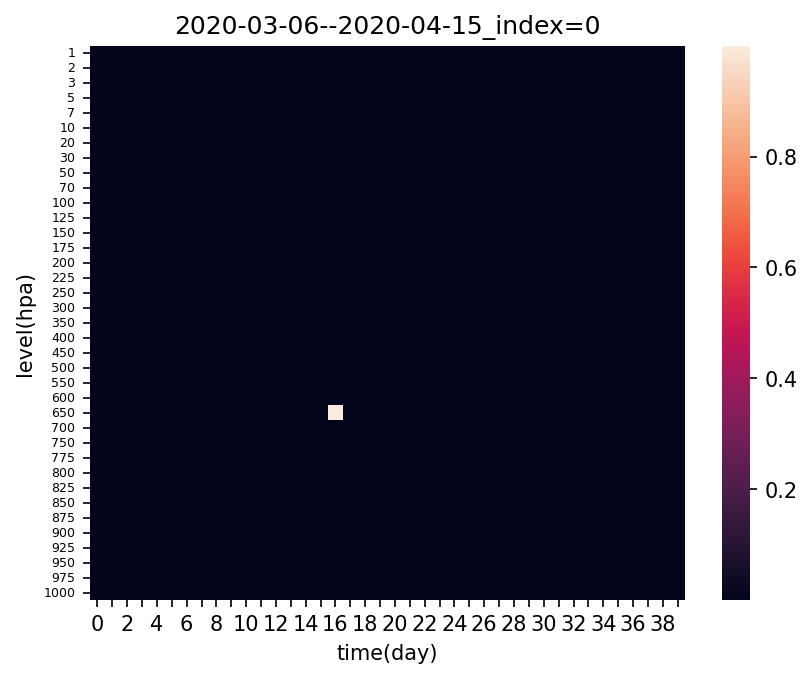

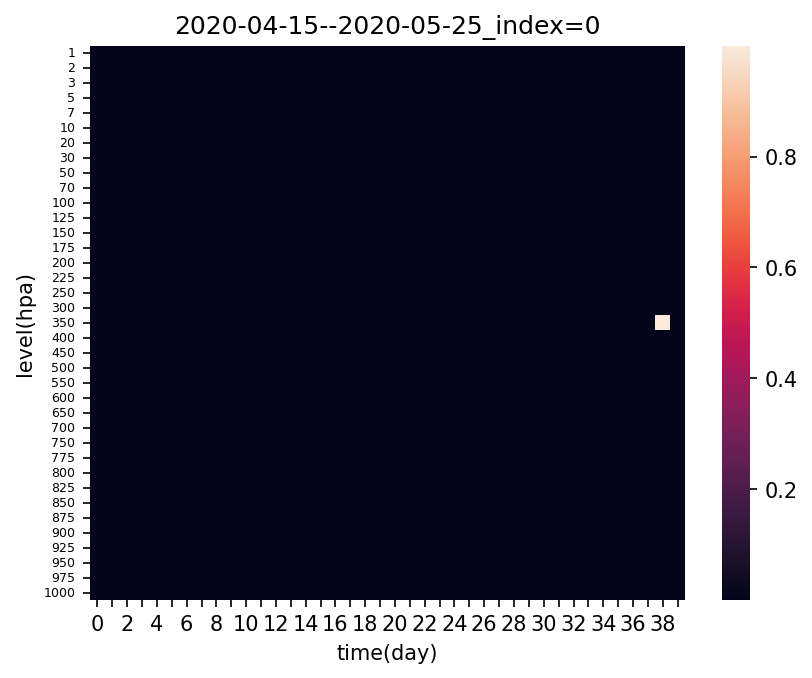

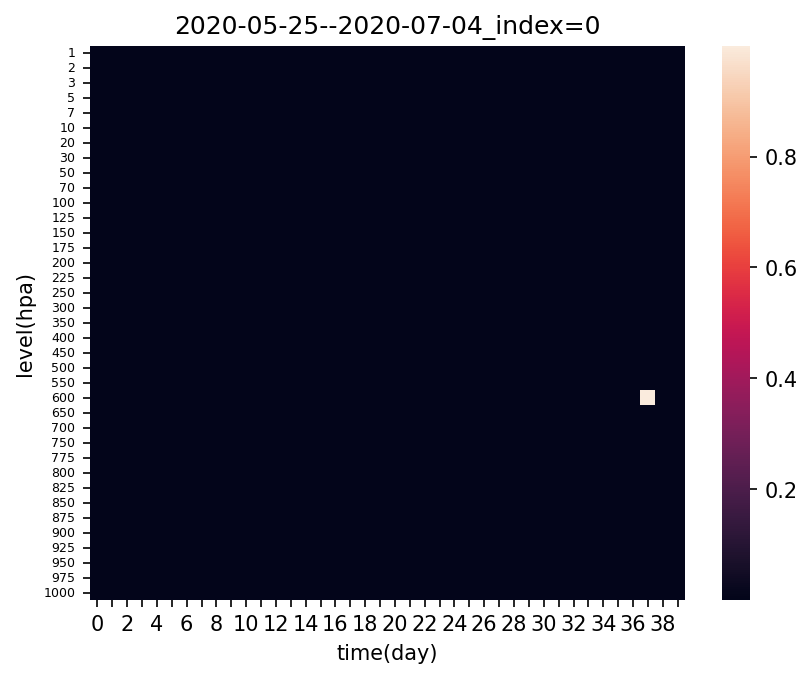

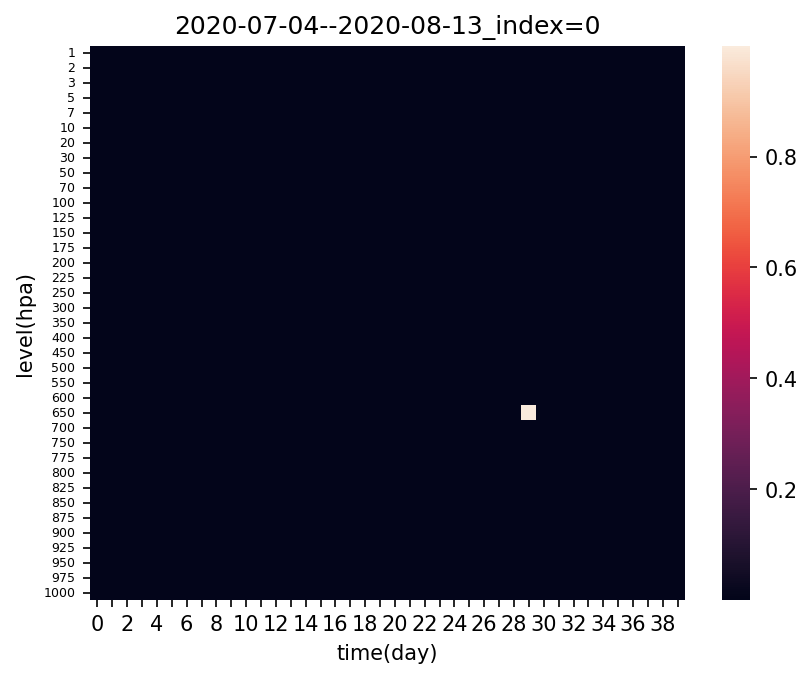

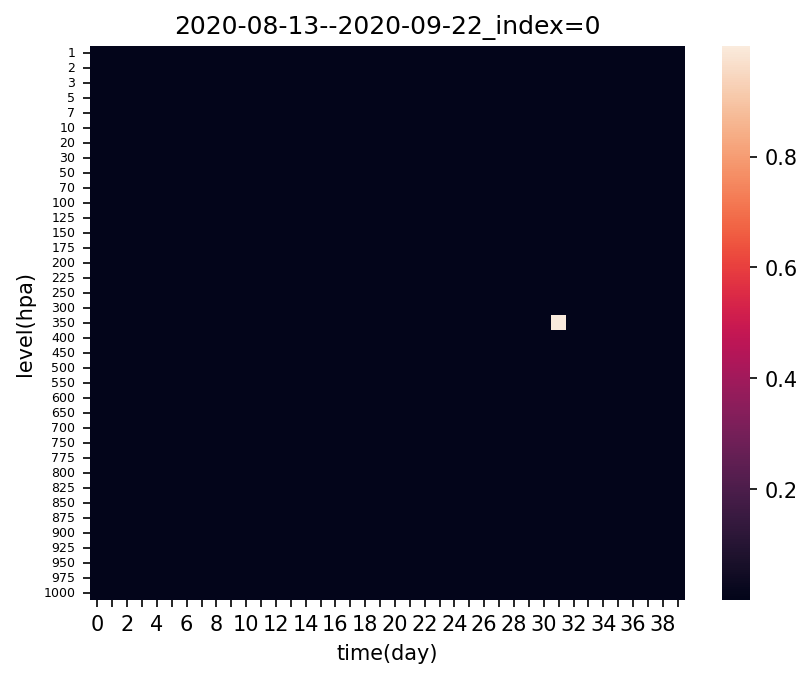

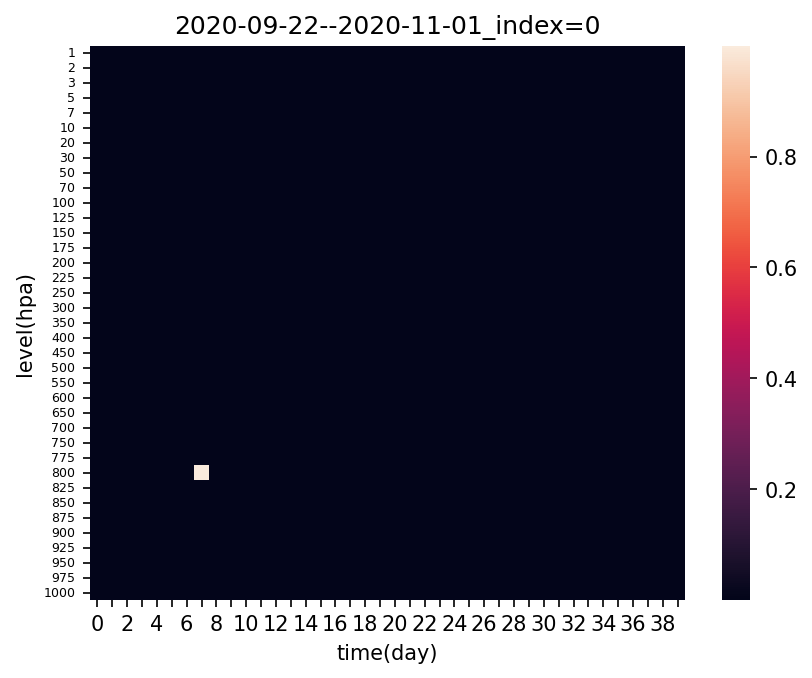

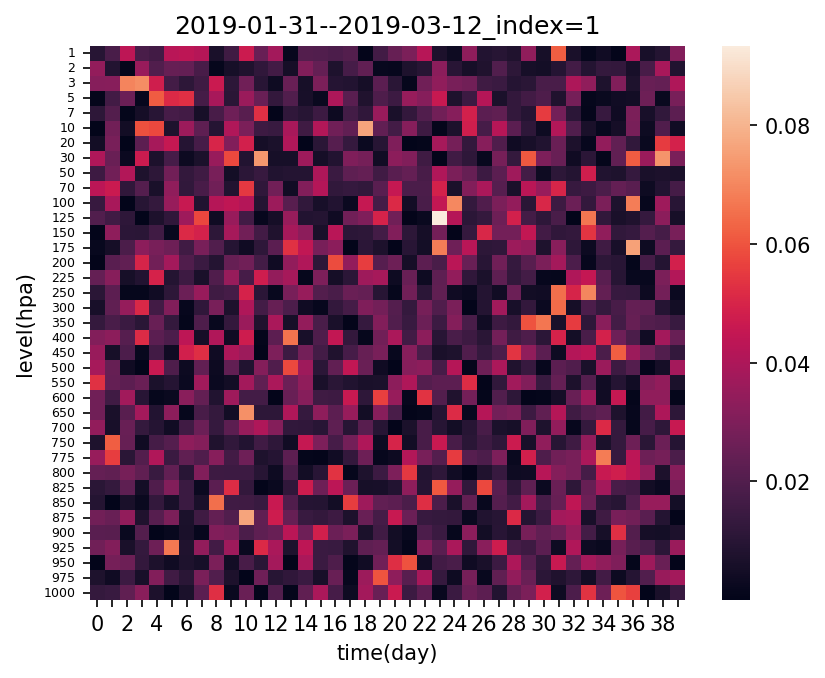

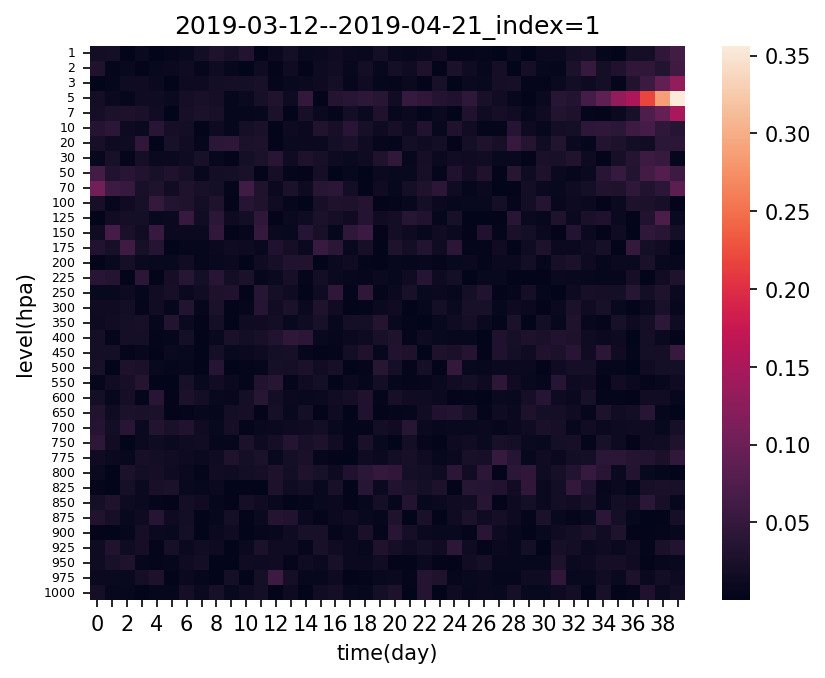

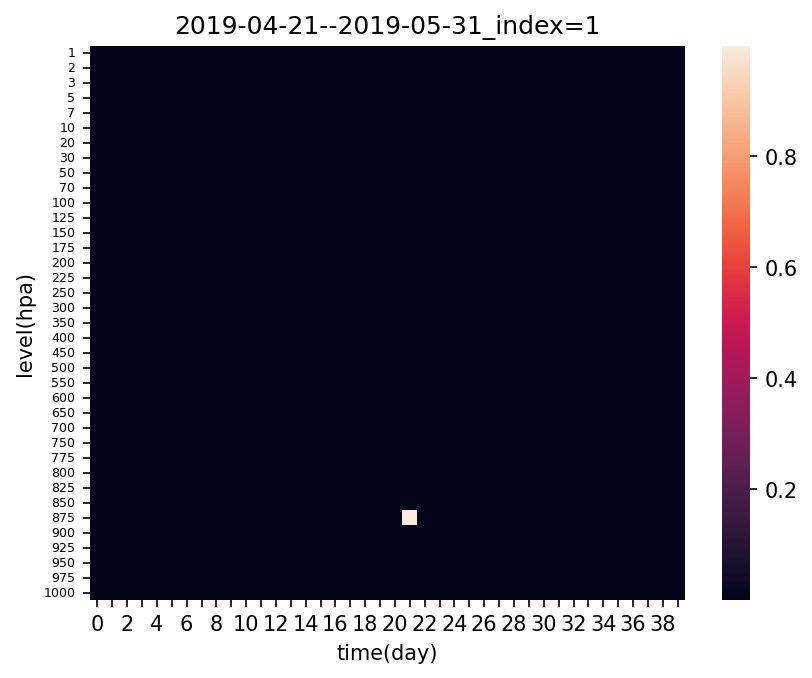

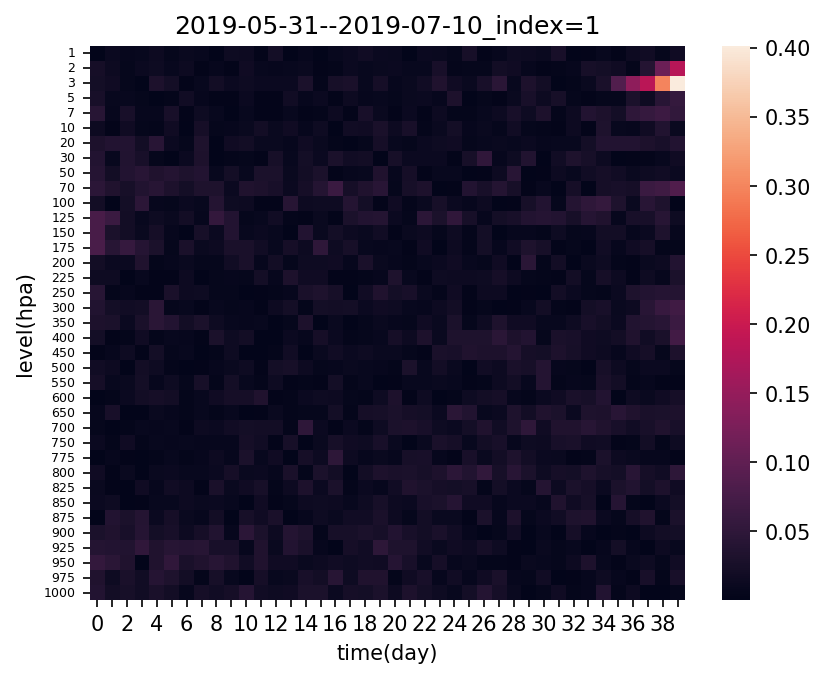

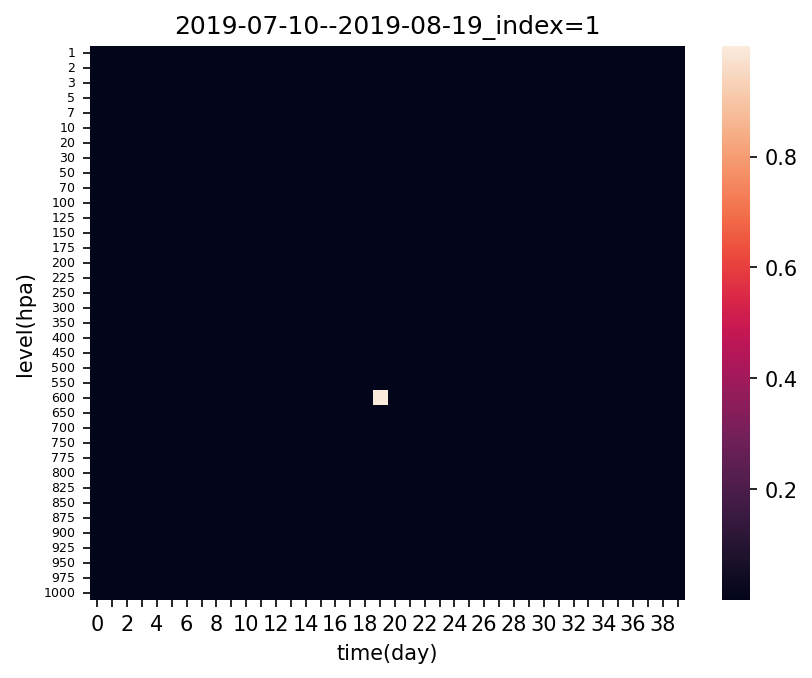

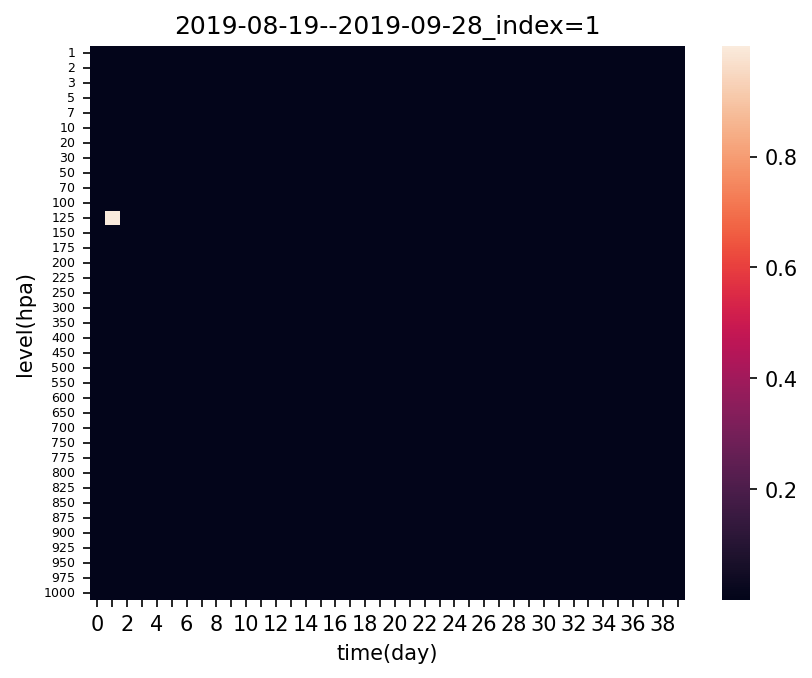

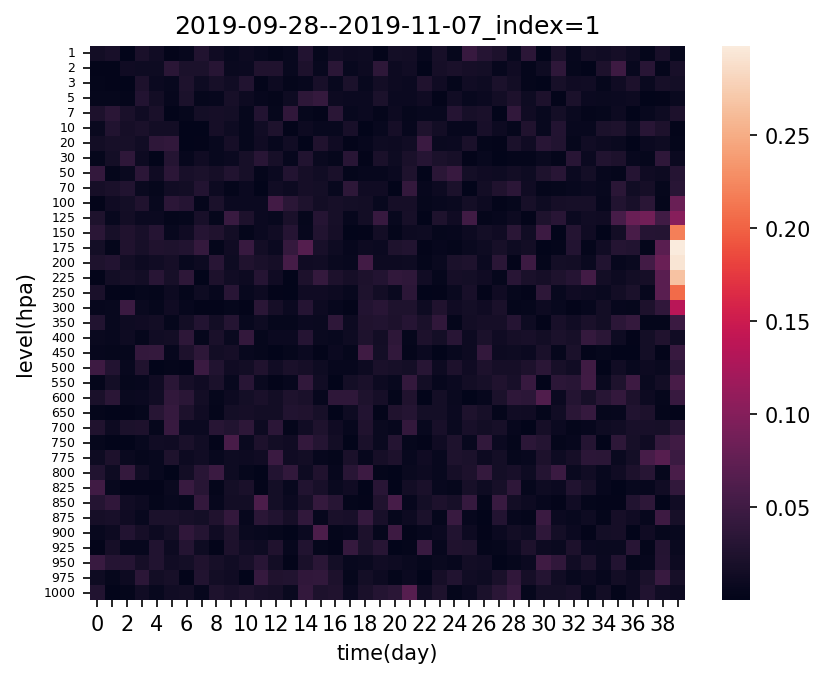

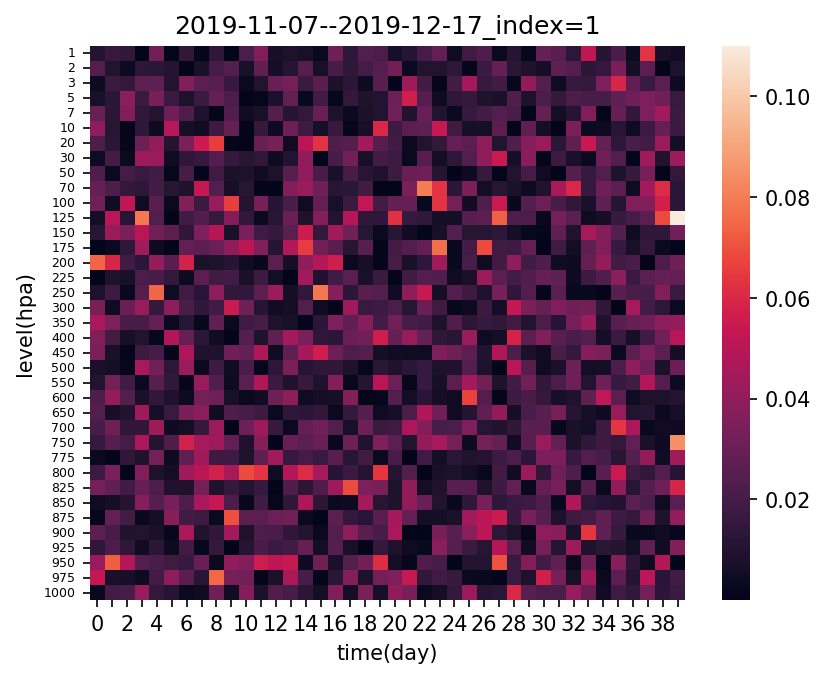

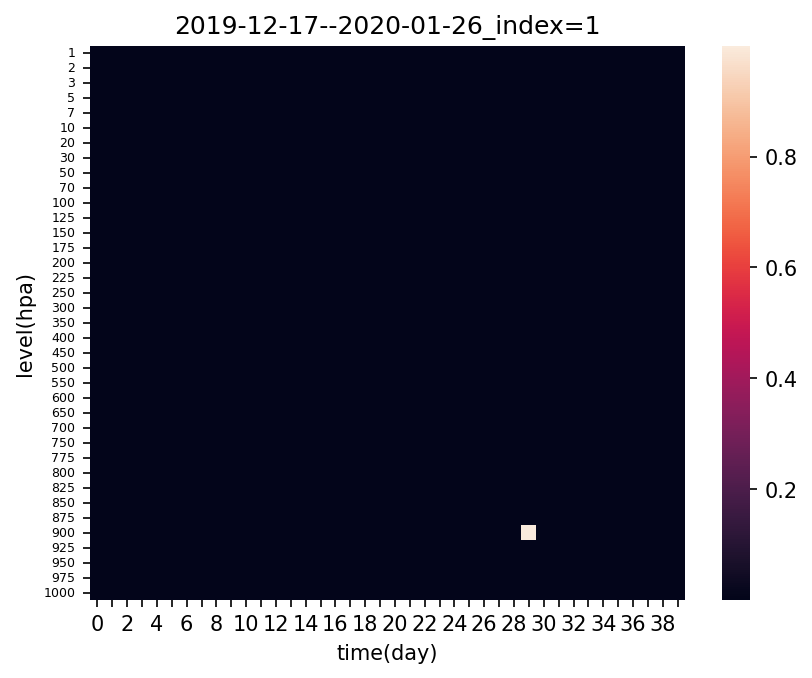

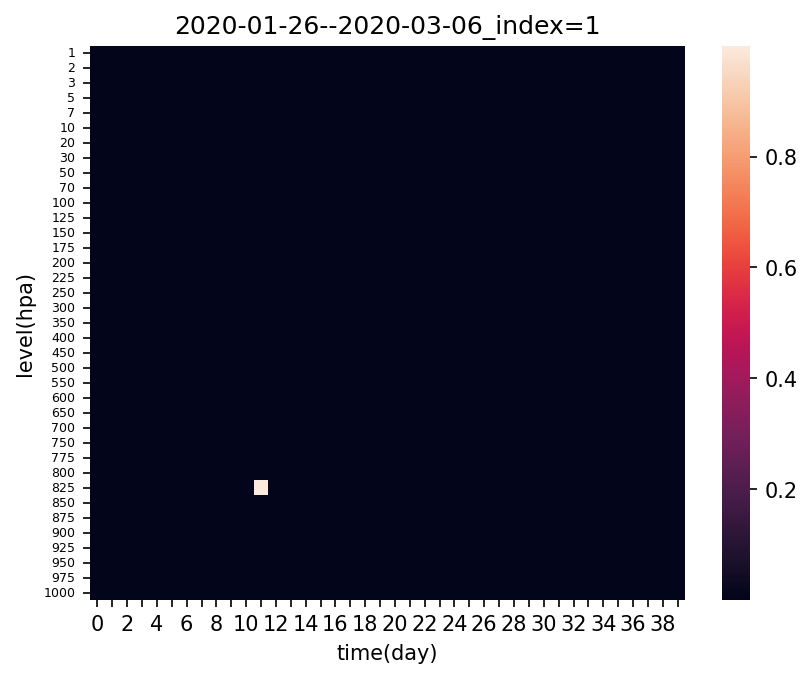

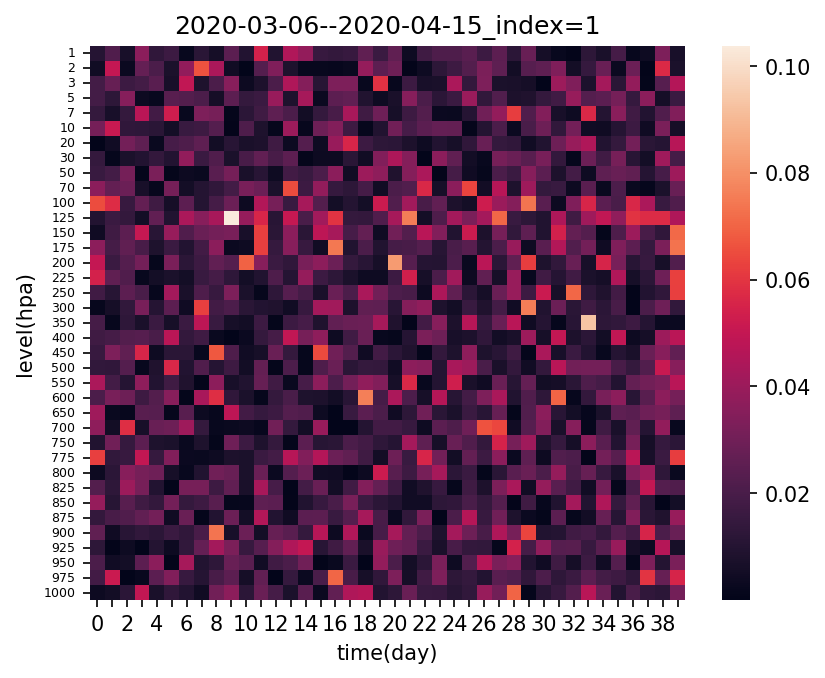

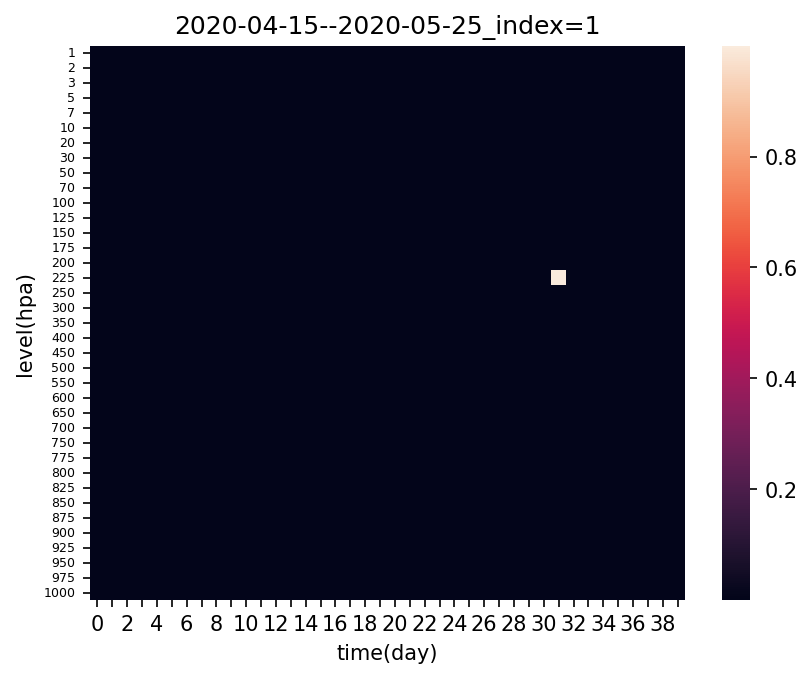

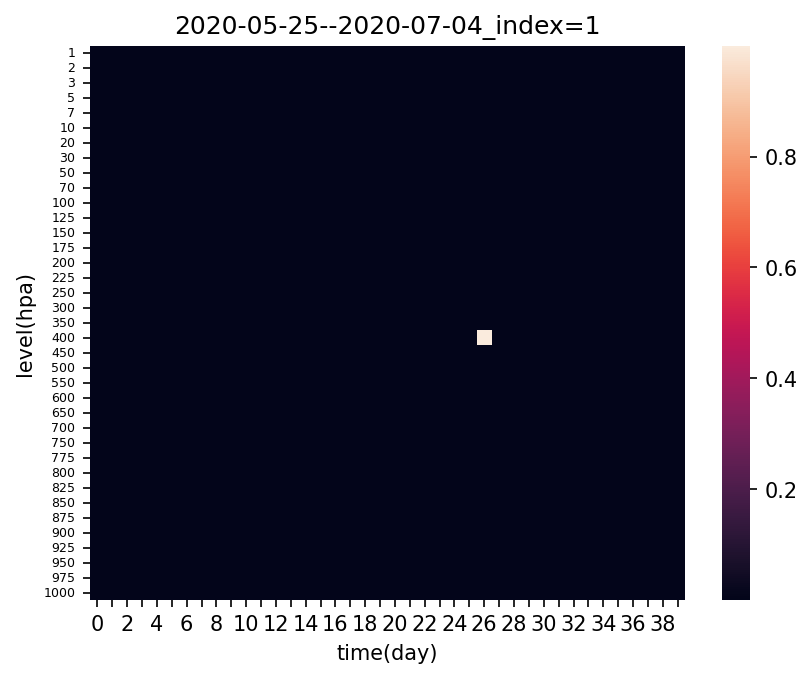

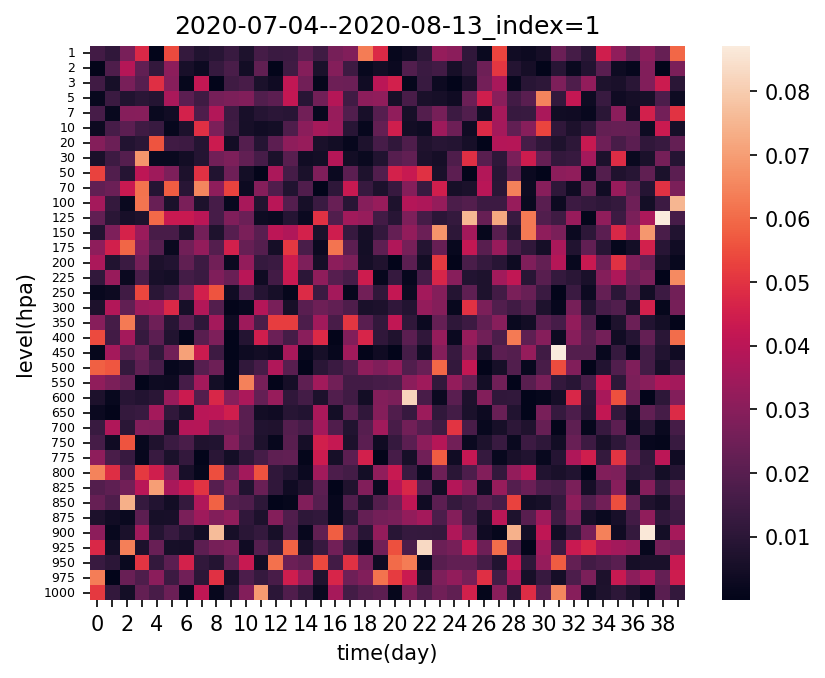

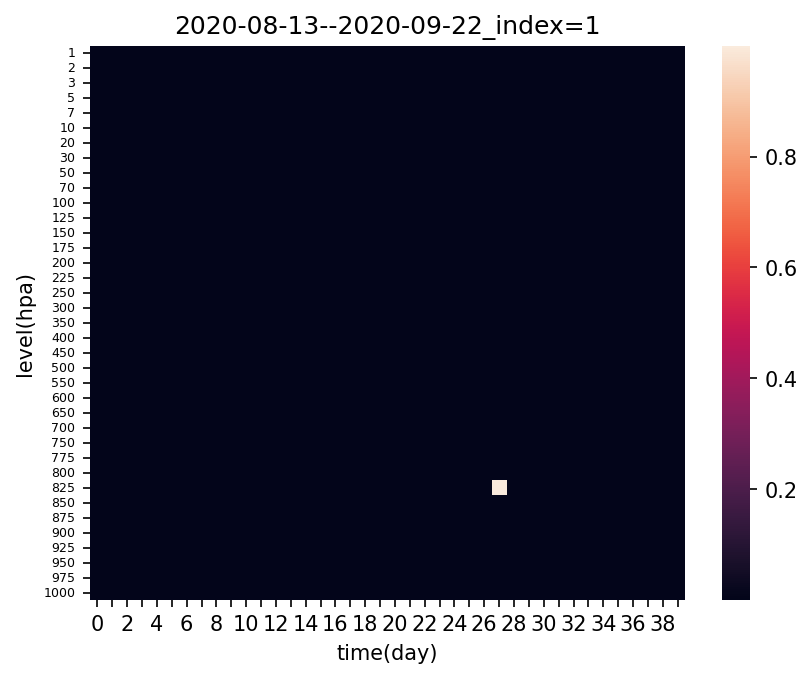

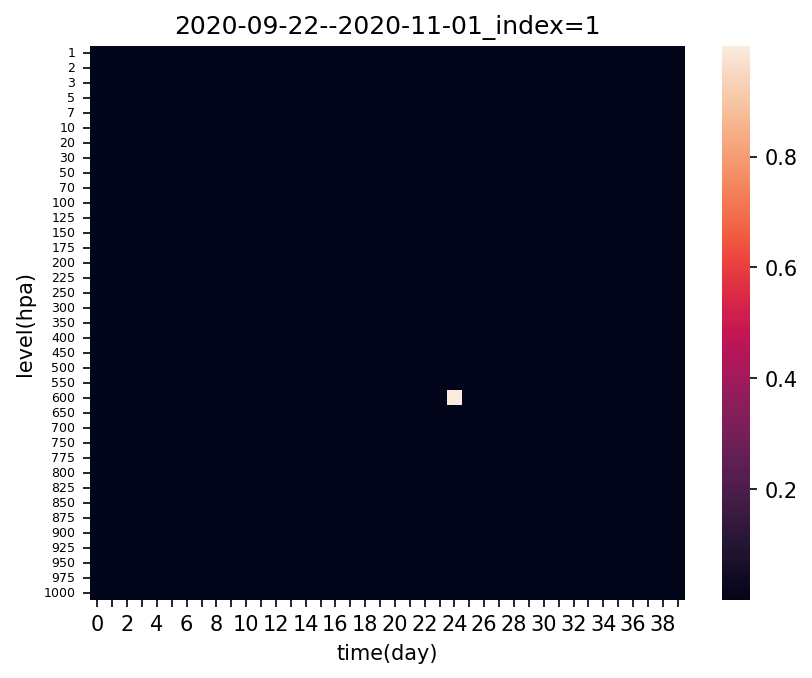

In [59]:
analysis_u(us, seq_len=40, dims=37, start=start, end=end, interval=interval, target=[0,1])

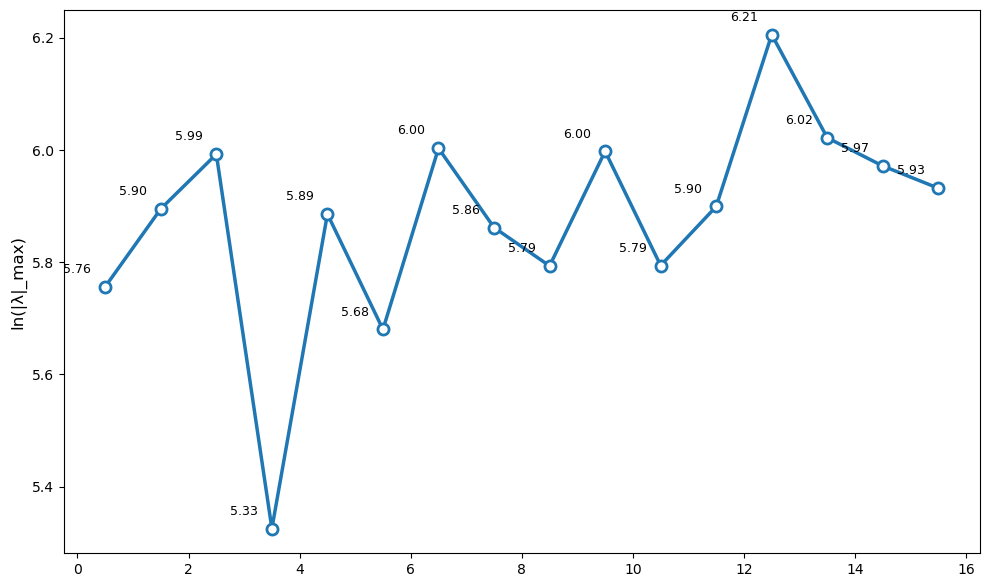

In [60]:
macro_analysis(us, mats, start, end, interval)